In [2]:
SEQ_LENGTHS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 
           2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576,
              2097152, 4194304, 8388608, 16777216]

In [3]:
def count_flops_est(model, batch_size=1, sequence_length=1):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle Echo State Transformer (nouvelle implémentation).
    
    Parameters:
    - model: Instance du modèle EST
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    T = sequence_length
    L = model.num_layers  # Nombre de couches
    M = model.memory_units  # Nombre d'unités mémoire
    R = model.memory_dim  # Dimension mémoire
    D = model.attention_dim  # Dimension attention
    I = model.enc_in  # Dimension d'entrée
    
    # Paramètres de sortie selon la tâche
    if hasattr(model.projection, 'out_features'):
        O = model.projection.out_features
    else:
        O = D  # Par défaut
    
    flops_breakdown = {}
    
    # ==================== EMBEDDING LAYER ====================
    
    # Input embedding (DataEmbedding)
    # Approximation: principalement la projection linéaire value_embedding
    flops_breakdown['input_embedding'] = B * T * I * D
    
    # ==================== EST LAYER LEVEL (répété L fois pour T timesteps) ====================
    
    layer_flops = {}
    
    # ==================== MEMORY FORWARD ====================
    
    memory_flops = {}
    
    # Adaptive Leak Rate computation
    # X @ adaptive_lr: [B, M, 1, D] @ [M, D, 1] -> [B, M, 1, 1]
    memory_flops['adaptive_lr_mm'] = B * M * D * 1 * T
    
    # Softmax sur adaptive_lr (division par temperature + softmax)
    memory_flops['adaptive_lr_softmax'] = B * M * 1 * 1 * 3 * T  # exp + sum + div
    
    # Feed computation (sparse matrix multiplication)
    # Estimation basée sur la connectivité fixe
    input_connectivity = model.est_layers[0].memory.input_connectivity
    feed_connections = int(input_connectivity * R)  # Nombre de connexions par colonne
    # Sparse MM: [B, M, 1, D] avec [M, D, R] -> [B, M, 1, R]
    memory_flops['feed_sparse_mm'] = B * M * D * feed_connections * T
    
    # Echo computation (sparse matrix multiplication + bias)
    res_connectivity = model.est_layers[0].memory.res_connectivity
    echo_connections = int(res_connectivity * R)  # Nombre de connexions par colonne
    # Sparse MM: [B, M, 1, R] avec [M, R, R] -> [B, M, 1, R]
    memory_flops['echo_sparse_mm'] = B * M * R * echo_connections * T
    # Addition du biais: [B, M, 1, R] + [M, 1, R]
    memory_flops['echo_bias_add'] = B * M * 1 * R * T
    
    # State update computation
    # (1 - lr) * state: [B, M, 1, 1] * [B, M, 1, R]
    memory_flops['state_update_mul1'] = B * M * 1 * R * T
    # lr * tanh(feed + echo): addition + tanh + multiplication
    memory_flops['feed_echo_add'] = B * M * 1 * R * T  # feed + echo
    memory_flops['tanh'] = B * M * 1 * R * T  # tanh
    memory_flops['state_update_mul2'] = B * M * 1 * R * T  # lr * tanh(...)
    # Final addition: ((1-lr)*state) + lr*tanh(...)
    memory_flops['state_update_final_add'] = B * M * 1 * R * T
    
    # Output computation: new_state @ Wout
    # [B, M, 1, R] @ [M, R, D] -> [B, M, 1, D]
    memory_flops['output_mm'] = B * M * R * D * T
    
    # ==================== ATTENTION MECHANISMS ====================
    
    attention_flops = {}
    
    # Attention on previous states
    # Q = emb @ Wq: [B, 1, 1, D] @ [M, D, D] -> [B, M, 1, D]
    attention_flops['Q_computation'] = B * M * D * D * T
    
    # K = Sout @ Wk: [B, M, M, D] @ [M, D, D] -> [B, M, M, D]
    attention_flops['K_computation'] = B * M * M * D * D * T
    
    # V = Sout @ Wv: [B, M, M, D] @ [M, D, D] -> [B, M, M, D]
    attention_flops['V_computation'] = B * M * M * D * D * T
    
    # Scaled dot product attention: Q @ K^T
    # [B, M, 1, D] @ [B, M, D, M] -> [B, M, 1, M]
    attention_flops['QKT_mm'] = B * M * 1 * D * M * T
    
    # Scale + Softmax
    attention_flops['scale_attention'] = B * M * 1 * M * T
    attention_flops['attention_softmax'] = B * M * 1 * M * 3 * T  # exp + sum + div
    
    # Attention weights @ V: [B, M, 1, M] @ [B, M, M, D] -> [B, M, 1, D]
    attention_flops['attention_V_mm'] = B * M * 1 * M * D * T
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + norm1
    attention_flops['residual_add1'] = B * M * D * T
    # RMS Norm: sqrt(mean(x^2)) et division (approximation: 3 ops par élément)
    attention_flops['norm1'] = B * M * D * 3 * T
    
    # Self-attention on current state
    # SQ, SK, SV computations: [B, M, D] @ [D, D] -> [B, M, D] (x3)
    attention_flops['SQ_computation'] = B * M * D * D * T
    attention_flops['SK_computation'] = B * M * D * D * T
    attention_flops['SV_computation'] = B * M * D * D * T
    
    # Self-attention: SQ @ SK^T: [B, M, D] @ [B, D, M] -> [B, M, M]
    attention_flops['self_QKT_mm'] = B * M * D * M * T
    
    # Scale + Softmax
    attention_flops['self_scale_attention'] = B * M * M * T
    attention_flops['self_attention_softmax'] = B * M * M * 3 * T
    
    # Self-attention weights @ SV: [B, M, M] @ [B, M, D] -> [B, M, D]
    attention_flops['self_attention_V_mm'] = B * M * M * D * T
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + norm2
    attention_flops['residual_add2'] = B * M * D * T
    attention_flops['norm2'] = B * M * D * 3 * T
    
    # ==================== FEED FORWARD ====================
    
    ff_flops = {}
    
    # Reduction: [B, M*D] @ [M*D, D] -> [B, D]
    ff_flops['reduction_mm'] = B * (M * D) * D * T
    
    # Feed forward in: [B, D] @ [D, 4*D] -> [B, 4*D]
    ff_flops['ff_in_mm'] = B * D * (4 * D) * T
    
    # GELU activation (approximation: 4 ops par élément)
    ff_flops['gelu'] = B * (4 * D) * 4 * T
    
    # Feed forward out: [B, 4*D] @ [4*D, D] -> [B, D]
    ff_flops['ff_out_mm'] = B * (4 * D) * D * T
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + norm3
    ff_flops['residual_add3'] = B * D * T
    ff_flops['norm3'] = B * D * 3 * T
    
    # ==================== ASSEMBLY LAYER FLOPS ====================
    
    # Somme des FLOPs pour une couche EST
    layer_total = (sum(memory_flops.values()) + 
                  sum(attention_flops.values()) + 
                  sum(ff_flops.values()))
    
    layer_flops['memory'] = memory_flops
    layer_flops['attention'] = attention_flops
    layer_flops['feed_forward'] = ff_flops
    layer_flops['total_per_layer'] = layer_total
    
    # ==================== OUTPUT PROJECTION ====================
    
    # Classification: flatten + projection
    if model.task_name == 'classification':
        # Flatten: [B, T, D] -> [B, T*D] (pas de FLOPs)
        # Projection: [B, T*D] @ [T*D, O] -> [B, O]
        flops_breakdown['output_projection'] = B * (T * D) * O
        # GELU + Dropout (pas de FLOPs pour dropout)
        flops_breakdown['output_activation'] = B * (T * D) * 2  # GELU approximation
    else:
        # Direct projection: [B, T, D] @ [D, O] -> [B, T, O]
        flops_breakdown['output_projection'] = B * T * D * O
        flops_breakdown['output_activation'] = 0
    
    # ==================== NORMALIZATION (si applicable) ====================
    
    normalization_flops = 0
    if model.task_name in ['long_term_forecast', 'short_term_forecast']:
        # Mean computation: B * T * D operations
        normalization_flops += B * T * D
        # Std computation: B * T * D operations (var + sqrt)
        normalization_flops += B * T * D * 2
        # Normalization: B * T * D operations (subtract + divide)
        normalization_flops += B * T * D * 2
        # Denormalization: B * T * D operations (multiply + add)
        normalization_flops += B * T * D * 2
    
    flops_breakdown['normalization'] = normalization_flops
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['layers'] = layer_flops
    flops_breakdown['total_layers'] = layer_total * L  # Multiplier par le nombre de couches
    
    total_flops = (flops_breakdown['input_embedding'] + 
                  flops_breakdown['total_layers'] + 
                  flops_breakdown['output_projection'] +
                  flops_breakdown['output_activation'] +
                  flops_breakdown['normalization'])
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_est(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour EST v2.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"ECHO STATE TRANSFORMER V2 - FLOPs BREAKDOWN")
    print("="*60)
    
    print(f"Input Embedding: {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Output Projection: {flops_breakdown['output_projection']:,} FLOPs")
    if flops_breakdown['output_activation'] > 0:
        print(f"Output Activation: {flops_breakdown['output_activation']:,} FLOPs")
    if flops_breakdown['normalization'] > 0:
        print(f"Normalization: {flops_breakdown['normalization']:,} FLOPs")
    
    print(f"\nPer Layer FLOPs: {flops_breakdown['layers']['total_per_layer']:,}")
    print(f"Total Layers FLOPs: {flops_breakdown['total_layers']:,}")
    
    print(f"\n--- Layer Breakdown ---")
    memory_total = sum(flops_breakdown['layers']['memory'].values())
    attention_total = sum(flops_breakdown['layers']['attention'].values())
    ff_total = sum(flops_breakdown['layers']['feed_forward'].values())
    
    layer_total = flops_breakdown['layers']['total_per_layer']
    print(f"Memory Operations: {memory_total:,} FLOPs ({memory_total/layer_total*100:.1f}%)")
    print(f"Attention Mechanisms: {attention_total:,} FLOPs ({attention_total/layer_total*100:.1f}%)")
    print(f"Feed Forward: {ff_total:,} FLOPs ({ff_total/layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed Memory Breakdown ---")
    for component, flops in flops_breakdown['layers']['memory'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)



# Test de la nouvelle fonction count_flops_est_v2 avec le modèle EST
from models.EST import Model as EST

# Configuration du modèle EST (adaptée à votre nouvelle implémentation)
configs_est = type('Config', (), {
    'task_name': 'anomaly_detection',  
    'pred_len': 10, 
    'seq_len': 10,
    'num_layers': 1,  # Moins de couches
    'd_model': 192,   # Dimension plus petite
    'dropout': 0.0,
    'memory_units': 4,  # Moins d'unités
    'memory_dim': 64,   # Dimension plus petite
    'memory_connectivity': 0.125,
    'enc_in': 10,
    'c_out': 10,
    'num_class': 10,
    'embed': 'timeF',
    'freq': 'h'
})()

# Créer le modèle EST
model_est = EST(configs_est)
print("Model parameters:", sum(p.numel() for p in model_est.parameters()))

# Test avec un exemple
batch_size = 32
sequence_length = 96
flops_breakdown, total_flops = count_flops_est(model_est, batch_size=batch_size, sequence_length=sequence_length)

# Afficher les résultats détaillés
print_flops_breakdown_est(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_est = []

for seq_len in SEQ_LENGTHS:
    flops_breakdown, total_flops = count_flops_est(model_est, batch_size=10, sequence_length=seq_len)
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_est.append(total_flops)


Model parameters: 1055439
ECHO STATE TRANSFORMER V2 - FLOPs BREAKDOWN
Input Embedding: 5,898,240 FLOPs
Output Projection: 5,898,240 FLOPs

Per Layer FLOPs: 7,046,860,800
Total Layers FLOPs: 7,046,860,800

--- Layer Breakdown ---
Memory Operations: 183,275,520 FLOPs (2.6%)
Attention Mechanisms: 5,492,834,304 FLOPs (77.9%)
Feed Forward: 1,370,750,976 FLOPs (19.5%)

--- Detailed Memory Breakdown ---
  adaptive_lr_mm: 2,359,296 FLOPs
  adaptive_lr_softmax: 36,864 FLOPs
  feed_sparse_mm: 18,874,368 FLOPs
  echo_sparse_mm: 6,291,456 FLOPs
  echo_bias_add: 786,432 FLOPs
  state_update_mul1: 786,432 FLOPs
  feed_echo_add: 786,432 FLOPs
  tanh: 786,432 FLOPs
  state_update_mul2: 786,432 FLOPs
  state_update_final_add: 786,432 FLOPs
  output_mm: 150,994,944 FLOPs
TOTAL FLOPs: 7,058,657,280
TOTAL GFLOPs: 7.059

=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===
Sequence Length:    1, Total FLOPs:   22,977,400, GFLOPs:    0.023
Sequence Length:    2, Total FLOPs:   45,954,800, GFLOPs:    0.046
Se

In [4]:
def count_flops_transformer_vanilla(model, batch_size=1, sequence_length=1, configs={}):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle Transformer Vanilla.
    
    Parameters:
    - model: Instance du modèle Transformer
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    S = sequence_length  # Sequence length

    # Récupérer les paramètres depuis le modèle
    # Encoder parameters
    encoder_layers = configs.get('e_layers')
    d_model = configs.get('d_model')
    n_heads = configs.get('n_heads')  # Valeur par défaut si non spécifié
    
    # Pour d_ff, on regarde les conv layers (conv1 et conv2)
    if encoder_layers > 0:
        d_ff = configs.get('d_ff')
    else:
        d_ff = d_model * 4

    I = configs.get('enc_in')  # Input features
    
    # Output dimension selon la tâche
    if model.task_name == 'classification':
        O = model.projection.out_features
    elif hasattr(model, 'projection'):
        O = model.projection.out_features
    elif model.task_name in ['long_term_forecast', 'short_term_forecast'] and hasattr(model, 'decoder'):
        O = model.decoder.projection.out_features
    else:
        O = d_model
    
    # Dimension par tête d'attention
    head_dim = d_model // n_heads
    
    flops_breakdown = {}
    
    # ==================== INPUT EMBEDDING ====================
    
    # Input embedding: Conv1d tokenization
    # Conv1d: [B, I, S] -> [B, d_model, S] avec kernel_size=3, padding=1
    conv_kernel_size = model.enc_embedding.value_embedding.tokenConv.kernel_size[0]
    flops_breakdown['input_embedding'] = B * S * I * d_model * conv_kernel_size
    
    # Positional embedding (pas de FLOPs, juste addition)
    # Temporal embedding: Linear layer [4 -> d_model]
    temporal_features = model.enc_embedding.temporal_embedding.embed.in_features
    flops_breakdown['positional_temporal_embedding'] = B * S * temporal_features * d_model
    
    # ==================== ENCODER LAYERS ====================
    
    encoder_layer_flops = {}
    
    # ==================== MULTI-HEAD ATTENTION ====================
    
    attention_flops = {}
    
    # Query, Key, Value projections
    # Input: [B, S, d_model] -> Output: [B, S, d_model] (pour chacune des 3 projections)
    attention_flops['Q_projection'] = B * S * d_model * d_model
    attention_flops['K_projection'] = B * S * d_model * d_model
    attention_flops['V_projection'] = B * S * d_model * d_model
    
    # Reshape pour multi-head: [B, S, d_model] -> [B, n_heads, S, head_dim]
    # Pas de FLOPs, juste un reshape
    
    # Attention scores: Q @ K^T
    # Q: [B, n_heads, S, head_dim], K^T: [B, n_heads, head_dim, S] -> [B, n_heads, S, S]
    attention_flops['attention_scores'] = B * n_heads * S * head_dim * S
    
    # Scale by sqrt(head_dim)
    attention_flops['scale_attention'] = B * n_heads * S * S
    
    # Softmax sur la dimension des clés (S)
    # Approximation: exp + sum + divide = 3 opérations par élément
    attention_flops['attention_softmax'] = B * n_heads * S * S * 3
    
    # Dropout (pas de FLOPs)
    
    # Attention weights @ V: [B, n_heads, S, S] @ [B, n_heads, S, head_dim] -> [B, n_heads, S, head_dim]
    attention_flops['attention_values'] = B * n_heads * S * S * head_dim
    
    # Concatenate heads: [B, n_heads, S, head_dim] -> [B, S, d_model]
    # Pas de FLOPs, juste un reshape
    
    # Output projection: [B, S, d_model] @ [d_model, d_model] -> [B, S, d_model]
    attention_flops['output_projection'] = B * S * d_model * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm1
    attention_flops['residual_add'] = B * S * d_model
    attention_flops['layer_norm1'] = B * S * d_model * 3  # mean, var, normalize
    
    # ==================== FEED FORWARD NETWORK (Conv-based) ====================
    
    feedforward_flops = {}
    
    # Conv1: [B, d_model, S] -> [B, d_ff, S] avec kernel_size=1
    feedforward_flops['conv1'] = B * S * d_model * d_ff
    
    # Activation (GELU)
    # Approximation: 2 opérations par élément pour GELU
    feedforward_flops['activation'] = B * S * d_ff * 2
    
    # Dropout (pas de FLOPs)
    
    # Conv2: [B, d_ff, S] -> [B, d_model, S] avec kernel_size=1
    feedforward_flops['conv2'] = B * S * d_ff * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm2
    feedforward_flops['residual_add'] = B * S * d_model
    feedforward_flops['layer_norm2'] = B * S * d_model * 3
    
    # ==================== ASSEMBLY ENCODER LAYER FLOPS ====================
    
    # Somme des FLOPs pour une couche d'encodeur
    encoder_layer_total = sum(attention_flops.values()) + sum(feedforward_flops.values())
    
    encoder_layer_flops['attention'] = attention_flops
    encoder_layer_flops['feedforward'] = feedforward_flops
    encoder_layer_flops['total_per_layer'] = encoder_layer_total
    
    # ==================== LAYER NORM FINALE ENCODER ====================
    
    encoder_norm_flops = 0
    if hasattr(model.encoder, 'norm') and model.encoder.norm is not None:
        encoder_norm_flops = B * S * d_model * 3
    
    # ==================== DECODER (si applicable) ====================
    
    decoder_flops = 0
    decoder_layer_flops = {}
    
    if model.task_name in ['long_term_forecast', 'short_term_forecast'] and hasattr(model, 'decoder'):
        # Paramètres decoder
        decoder_layers = len(model.decoder.layers) if hasattr(model.decoder, 'layers') else 0
        
        if decoder_layers > 0:
            # Dec embedding (similaire à enc_embedding)
            dec_embedding_flops = B * S * I * d_model * conv_kernel_size + B * S * temporal_features * d_model
            
            # Pour chaque couche decoder (structure similaire à l'encoder)
            decoder_attention_flops = {}
            
            # Self-attention (avec masque causal)
            decoder_attention_flops['self_Q_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_K_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_V_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_attention_scores'] = B * n_heads * S * head_dim * S
            decoder_attention_flops['self_scale_attention'] = B * n_heads * S * S
            decoder_attention_flops['self_attention_softmax'] = B * n_heads * S * S * 3
            decoder_attention_flops['self_attention_values'] = B * n_heads * S * S * head_dim
            decoder_attention_flops['self_output_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_residual'] = B * S * d_model
            decoder_attention_flops['self_norm1'] = B * S * d_model * 3
            
            # Cross-attention (decoder vers encoder)
            decoder_attention_flops['cross_Q_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_K_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_V_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_attention_scores'] = B * n_heads * S * head_dim * S
            decoder_attention_flops['cross_scale_attention'] = B * n_heads * S * S
            decoder_attention_flops['cross_attention_softmax'] = B * n_heads * S * S * 3
            decoder_attention_flops['cross_attention_values'] = B * n_heads * S * S * head_dim
            decoder_attention_flops['cross_output_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_residual'] = B * S * d_model
            decoder_attention_flops['cross_norm2'] = B * S * d_model * 3
            
            # Feed forward decoder (Conv-based)
            decoder_ff_flops = {}
            decoder_ff_flops['conv1'] = B * S * d_model * d_ff
            decoder_ff_flops['activation'] = B * S * d_ff * 2
            decoder_ff_flops['conv2'] = B * S * d_ff * d_model
            decoder_ff_flops['residual_add'] = B * S * d_model
            decoder_ff_flops['layer_norm3'] = B * S * d_model * 3
            
            # Total par couche decoder
            decoder_layer_total = sum(decoder_attention_flops.values()) + sum(decoder_ff_flops.values())
            
            decoder_layer_flops['attention'] = decoder_attention_flops
            decoder_layer_flops['feedforward'] = decoder_ff_flops
            decoder_layer_flops['total_per_layer'] = decoder_layer_total
            
            # Total decoder
            decoder_flops = (dec_embedding_flops + 
                            decoder_layer_total * decoder_layers + 
                            B * S * d_model * 3)  # Norm finale
            
            # Projection finale
            decoder_projection_flops = B * S * d_model * O
            
            flops_breakdown['dec_embedding'] = dec_embedding_flops
            flops_breakdown['decoder_layers'] = decoder_layer_total * decoder_layers
            flops_breakdown['decoder_projection'] = decoder_projection_flops
    
    # ==================== OUTPUT PROJECTION ====================
    
    output_flops = 0
    
    if model.task_name == 'classification':
        # Flatten + GELU + Dropout + Projection
        # output = output.reshape(B, -1): pas de FLOPs
        # GELU: [B, S * d_model]
        gelu_flops = B * S * d_model * 2
        # Projection: [B, S * d_model] @ [S * d_model, num_classes] -> [B, num_classes]
        projection_flops = B * (S * d_model) * O
        
        output_flops = gelu_flops + projection_flops
        
        flops_breakdown['output_activation'] = gelu_flops
        flops_breakdown['output_projection'] = projection_flops
        
    elif model.task_name in ['imputation', 'anomaly_detection']:
        # Direct projection: [B, S, d_model] @ [d_model, O] -> [B, S, O]
        output_flops = B * S * d_model * O
        flops_breakdown['output_projection'] = output_flops
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['input_embedding'] = flops_breakdown['input_embedding']
    flops_breakdown['positional_temporal_embedding'] = flops_breakdown['positional_temporal_embedding']
    flops_breakdown['encoder_layers'] = encoder_layer_flops
    flops_breakdown['total_encoder_layers'] = encoder_layer_total * encoder_layers
    flops_breakdown['encoder_norm'] = encoder_norm_flops
    
    if decoder_flops > 0:
        flops_breakdown['decoder_layers_detail'] = decoder_layer_flops
        flops_breakdown['total_decoder'] = decoder_flops
    
    total_flops = (flops_breakdown['input_embedding'] + 
                  flops_breakdown['positional_temporal_embedding'] +
                  flops_breakdown['total_encoder_layers'] + 
                  flops_breakdown['encoder_norm'] +
                  decoder_flops +
                  output_flops)
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_transformer_vanilla(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour le Transformer Vanilla.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"TRANSFORMER VANILLA - FLOPs BREAKDOWN")
    print("="*60)
    
    print(f"Input Embedding: {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Positional/Temporal Embedding: {flops_breakdown['positional_temporal_embedding']:,} FLOPs")
    print(f"Encoder Norm: {flops_breakdown['encoder_norm']:,} FLOPs")
    
    if 'output_projection' in flops_breakdown:
        print(f"Output Projection: {flops_breakdown['output_projection']:,} FLOPs")
    if 'output_activation' in flops_breakdown:
        print(f"Output Activation: {flops_breakdown['output_activation']:,} FLOPs")
    
    print(f"\n=== ENCODER ===")
    print(f"Per Encoder Layer FLOPs: {flops_breakdown['encoder_layers']['total_per_layer']:,}")
    print(f"Total Encoder Layers FLOPs: {flops_breakdown['total_encoder_layers']:,}")
    
    print(f"\n--- Encoder Layer Breakdown ---")
    encoder_attention_total = sum(flops_breakdown['encoder_layers']['attention'].values())
    encoder_ff_total = sum(flops_breakdown['encoder_layers']['feedforward'].values())
    encoder_layer_total = flops_breakdown['encoder_layers']['total_per_layer']
    
    print(f"Multi-Head Attention: {encoder_attention_total:,} FLOPs ({encoder_attention_total/encoder_layer_total*100:.1f}%)")
    print(f"Feed Forward Network (Conv): {encoder_ff_total:,} FLOPs ({encoder_ff_total/encoder_layer_total*100:.1f}%)")
    
    # Decoder si présent
    if 'total_decoder' in flops_breakdown:
        print(f"\n=== DECODER ===")
        print(f"Dec Embedding: {flops_breakdown['dec_embedding']:,} FLOPs")
        print(f"Total Decoder Layers: {flops_breakdown['decoder_layers']:,} FLOPs")
        print(f"Decoder Projection: {flops_breakdown['decoder_projection']:,} FLOPs")
        print(f"Total Decoder: {flops_breakdown['total_decoder']:,} FLOPs")
        
        if 'decoder_layers_detail' in flops_breakdown:
            decoder_attention_total = sum(flops_breakdown['decoder_layers_detail']['attention'].values())
            decoder_ff_total = sum(flops_breakdown['decoder_layers_detail']['feedforward'].values())
            decoder_layer_total = flops_breakdown['decoder_layers_detail']['total_per_layer']
            
            print(f"\n--- Decoder Layer Breakdown ---")
            print(f"Attention Mechanisms: {decoder_attention_total:,} FLOPs ({decoder_attention_total/decoder_layer_total*100:.1f}%)")
            print(f"Feed Forward Network: {decoder_ff_total:,} FLOPs ({decoder_ff_total/decoder_layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed Encoder Attention Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['attention'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Encoder Feed Forward Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['feedforward'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)

# Test du modèle Transformer Vanilla
from models.Transformer import Model as TransformerVanilla

# Configuration pour le modèle Transformer
conf_transformer = {
    'task_name': 'anomaly_detection', 
    'pred_len': 1,
    'seq_len': 10,
    'enc_in': 10,        # Features d'entrée
    'dec_in': 10,        # Features decoder (si applicable)
    'c_out': 1,          # Features de sortie
    'num_class': 10,     # Nombre de classes pour classification
    'd_model': 256,       # Dimension du modèle
    'n_heads': 8,        # Nombre de têtes d'attention
    'd_ff': 512,         # Dimension feedforward
    'e_layers': 2,       # Nombre de couches encoder
    'd_layers': 1,       # Nombre de couches decoder
    'factor': 5,         # Facteur pour attention
    'dropout': 0.1,
    'activation': 'gelu',
    'embed': 'timeF',
    'freq': 'h'
}
configs_transformer = type('Config', (), conf_transformer)()

# Créer le modèle
model_transformer = TransformerVanilla(configs_transformer)
print("Model parameters:", sum(p.numel() for p in model_transformer.parameters()))

print("=== MODÈLE TRANSFORMER VANILLA CRÉÉ ===")
print(f"Task: {model_transformer.task_name}")
if hasattr(model_transformer, 'decoder'):
    print(f"Decoder layers: {len(model_transformer.decoder.attn_layers)}")

# Test des FLOPs
batch_size = 32
sequence_length = 96

flops_breakdown, total_flops = count_flops_transformer_vanilla(
    model_transformer, batch_size=batch_size, sequence_length=sequence_length, configs=conf_transformer
)

# Afficher les résultats
print_flops_breakdown_transformer_vanilla(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_transformer_vanilla = []

for seq_len in SEQ_LENGTHS:
    flops_breakdown, total_flops = count_flops_transformer_vanilla(
        model_transformer, batch_size=10, sequence_length=seq_len, configs=conf_transformer
    )
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_transformer_vanilla.append(total_flops)

Model parameters: 1063681
=== MODÈLE TRANSFORMER VANILLA CRÉÉ ===
Task: anomaly_detection
TRANSFORMER VANILLA - FLOPs BREAKDOWN
Input Embedding: 23,592,960 FLOPs
Positional/Temporal Embedding: 3,145,728 FLOPs
Encoder Norm: 2,359,296 FLOPs
Output Projection: 786,432 FLOPs

=== ENCODER ===
Per Encoder Layer FLOPs: 1,780,482,048
Total Encoder Layers FLOPs: 3,560,964,096

--- Encoder Layer Breakdown ---
Multi-Head Attention: 968,884,224 FLOPs (54.4%)
Feed Forward Network (Conv): 811,597,824 FLOPs (45.6%)

--- Detailed Encoder Attention Breakdown ---
  Q_projection: 201,326,592 FLOPs
  K_projection: 201,326,592 FLOPs
  V_projection: 201,326,592 FLOPs
  attention_scores: 75,497,472 FLOPs
  scale_attention: 2,359,296 FLOPs
  attention_softmax: 7,077,888 FLOPs
  attention_values: 75,497,472 FLOPs
  output_projection: 201,326,592 FLOPs
  residual_add: 786,432 FLOPs
  layer_norm1: 2,359,296 FLOPs

--- Detailed Encoder Feed Forward Breakdown ---
  conv1: 402,653,184 FLOPs
  activation: 3,145,728 

/Users/naowak/Thesis/code/Time-Series-Library/tsl_venv/lib/python3.11/site-packages/local_attention/rotary.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/Users/naowak/Thesis/code/Time-Series-Library/tsl_venv/lib/python3.11/site-packages/local_attention/rotary.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [5]:
def count_flops_mamba(model, batch_size=1, sequence_length=1, configs={}):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle Mamba.
    
    Parameters:
    - model: Instance du modèle Mamba
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    - configs: Configuration du modèle (dict)
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    L = sequence_length  # Sequence length
    
    # Récupérer les paramètres depuis la configuration
    d_model = configs.get('d_model')  # Dimension du modèle
    expand = configs.get('expand', 2)  # Facteur d'expansion
    d_inner = d_model * expand  # Dimension interne
    dt_rank = math.ceil(d_model / 16)  # Rang pour delta (même calcul que dans le modèle)
    n_layers = configs.get('e_layers')  # Nombre de couches
    
    # Input/Output dimensions
    I = configs.get('enc_in')  # Input features
    O = configs.get('c_out')  # Output features
    
    # Paramètres SSM
    n = configs.get('d_ff')  # d_ff (dimension état)
    d_conv = configs.get('d_conv')  # Taille kernel conv
    
    flops_breakdown = {}
    
    # ==================== INPUT EMBEDDING ====================
    
    # Input embedding: X @ W -> [B, L, I] @ [I, d_model] -> [B, L, d_model]
    flops_breakdown['input_embedding'] = B * L * I * d_model
    
    # Positional/Temporal embedding (approximation)
    flops_breakdown['positional_temporal_embedding'] = B * L * d_model * 2
    
    # ==================== MAMBA LAYERS ====================
    
    mamba_layer_flops = {}
    
    # ==================== RMS NORM (avant chaque couche) ====================
    
    norm_flops = {}
    
    # RMS Norm: sqrt(mean(x^2)) + scale
    # Approximation: 3 opérations par élément (square, mean, sqrt+scale)
    norm_flops['rms_norm'] = B * L * d_model * 3
    
    # ==================== MAMBA BLOCK ====================
    
    mamba_block_flops = {}
    
    # Input projection: [B, L, d_model] @ [d_model, 2*d_inner] -> [B, L, 2*d_inner]
    mamba_block_flops['in_proj'] = B * L * d_model * (2 * d_inner)
    
    # Split en x et res (pas de FLOPs)
    
    # ==================== CONVOLUTION 1D ====================
    
    conv_flops = {}
    
    # Conv1d: [B, d_inner, L] avec kernel_size=d_conv, groups=d_inner
    # Chaque groupe fait une convolution indépendante
    conv_flops['conv1d'] = B * L * d_inner * d_conv
    
    # SiLU activation: approximation 2 opérations par élément
    conv_flops['silu_activation'] = B * L * d_inner * 2
    
    # ==================== STATE SPACE MODEL (SSM) ====================
    
    ssm_flops = {}
    
    # x_proj: [B, L, d_inner] @ [d_inner, dt_rank + 2*n] -> [B, L, dt_rank + 2*n]
    ssm_flops['x_proj'] = B * L * d_inner * (dt_rank + 2 * n)
    
    # Split en delta, B, C (pas de FLOPs)
    
    # dt_proj: [B, L, dt_rank] @ [dt_rank, d_inner] -> [B, L, d_inner]
    ssm_flops['dt_proj'] = B * L * dt_rank * d_inner
    
    # Softplus sur delta: approximation 2 opérations par élément
    ssm_flops['softplus_delta'] = B * L * d_inner * 2
    
    # Selective scan computation
    # deltaA = exp(delta ⊗ A): [B, L, d_inner, n]
    # Einsum: delta [B, L, d_inner] × A [d_inner, n] -> [B, L, d_inner, n]
    ssm_flops['deltaA_einsum'] = B * L * d_inner * n
    ssm_flops['deltaA_exp'] = B * L * d_inner * n
    
    # deltaB_u = delta ⊗ B ⊗ u: [B, L, d_inner, n]
    # Triple einsum: delta [B, L, d_inner] × B [B, L, n] × u [B, L, d_inner]
    ssm_flops['deltaB_u_einsum'] = B * L * d_inner * n * 2  # 2 multiplications
    
    # Selective scan séquentiel (pour L timesteps)
    # Pour chaque timestep i:
    #   x = deltaA[:, i] * x + deltaB_u[:, i]: [B, d_inner, n]
    #   y = x ⊗ C[:, i]: [B, d_inner] 
    ssm_flops['selective_scan_update'] = L * B * d_inner * n * 2  # mult + add pour x
    ssm_flops['selective_scan_output'] = L * B * d_inner * n      # einsum pour y
    
    # Residual connection avec D: y + u * D
    ssm_flops['residual_D'] = B * L * d_inner * 2  # mult + add
    
    # ==================== OUTPUT PROCESSING ====================
    
    output_flops = {}
    
    # SiLU sur res: approximation 2 opérations par élément
    output_flops['silu_res'] = B * L * d_inner * 2
    
    # Element-wise multiplication: y * silu(res)
    output_flops['elementwise_mult'] = B * L * d_inner
    
    # Output projection: [B, L, d_inner] @ [d_inner, d_model] -> [B, L, d_model]
    output_flops['out_proj'] = B * L * d_inner * d_model
    
    # ==================== RESIDUAL CONNECTION ====================
    
    residual_flops = {}
    
    # Residual add: mixer_output + input
    residual_flops['residual_add'] = B * L * d_model
    
    # ==================== ASSEMBLY MAMBA LAYER FLOPS ====================
    
    # Somme des FLOPs pour une couche Mamba
    mamba_layer_total = (sum(norm_flops.values()) + 
                        sum(mamba_block_flops.values()) + 
                        sum(conv_flops.values()) + 
                        sum(ssm_flops.values()) + 
                        sum(output_flops.values()) + 
                        sum(residual_flops.values()))
    
    mamba_layer_flops['norm'] = norm_flops
    mamba_layer_flops['mamba_block'] = mamba_block_flops
    mamba_layer_flops['conv'] = conv_flops
    mamba_layer_flops['ssm'] = ssm_flops
    mamba_layer_flops['output'] = output_flops
    mamba_layer_flops['residual'] = residual_flops
    mamba_layer_flops['total_per_layer'] = mamba_layer_total
    
    # ==================== FINAL NORMALIZATION ====================
    
    final_norm_flops = B * L * d_model * 3
    
    # ==================== OUTPUT LAYER ====================
    
    # Output linear layer: [B, L, d_model] @ [d_model, O] -> [B, L, O]
    output_layer_flops = B * L * d_model * O
    
    # ==================== NORMALIZATION (pour forecasting) ====================
    
    normalization_flops = 0
    if configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        # Mean computation: B * L * I operations
        normalization_flops += B * L * I
        # Std computation: var + sqrt
        normalization_flops += B * L * I * 2
        # Normalization: subtract + divide
        normalization_flops += B * L * I * 2
        # Denormalization: multiply + add
        normalization_flops += B * L * I * 2
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['input_embedding'] = flops_breakdown['input_embedding']
    flops_breakdown['positional_temporal_embedding'] = flops_breakdown['positional_temporal_embedding']
    flops_breakdown['mamba_layers'] = mamba_layer_flops
    flops_breakdown['total_mamba_layers'] = mamba_layer_total * n_layers
    flops_breakdown['final_norm'] = final_norm_flops
    flops_breakdown['output_layer'] = output_layer_flops
    flops_breakdown['normalization'] = normalization_flops
    
    total_flops = (flops_breakdown['input_embedding'] + 
                  flops_breakdown['positional_temporal_embedding'] +
                  flops_breakdown['total_mamba_layers'] + 
                  flops_breakdown['final_norm'] +
                  flops_breakdown['output_layer'] +
                  flops_breakdown['normalization'])
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_mamba(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour le modèle Mamba.
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"MAMBA - FLOPs BREAKDOWN")
    print("="*60)
    
    print(f"Input Embedding: {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Positional/Temporal Embedding: {flops_breakdown['positional_temporal_embedding']:,} FLOPs")
    print(f"Final Norm: {flops_breakdown['final_norm']:,} FLOPs")
    print(f"Output Layer: {flops_breakdown['output_layer']:,} FLOPs")
    if flops_breakdown['normalization'] > 0:
        print(f"Normalization: {flops_breakdown['normalization']:,} FLOPs")
    
    print(f"\n=== MAMBA LAYERS ===")
    print(f"Per Mamba Layer FLOPs: {flops_breakdown['mamba_layers']['total_per_layer']:,}")
    print(f"Total Mamba Layers FLOPs: {flops_breakdown['total_mamba_layers']:,}")
    
    print(f"\n--- Mamba Layer Breakdown ---")
    norm_total = sum(flops_breakdown['mamba_layers']['norm'].values())
    mamba_block_total = sum(flops_breakdown['mamba_layers']['mamba_block'].values())
    conv_total = sum(flops_breakdown['mamba_layers']['conv'].values())
    ssm_total = sum(flops_breakdown['mamba_layers']['ssm'].values())
    output_total = sum(flops_breakdown['mamba_layers']['output'].values())
    residual_total = sum(flops_breakdown['mamba_layers']['residual'].values())
    
    layer_total = flops_breakdown['mamba_layers']['total_per_layer']
    print(f"RMS Normalization: {norm_total:,} FLOPs ({norm_total/layer_total*100:.1f}%)")
    print(f"Input Projection: {mamba_block_total:,} FLOPs ({mamba_block_total/layer_total*100:.1f}%)")
    print(f"Convolution 1D: {conv_total:,} FLOPs ({conv_total/layer_total*100:.1f}%)")
    print(f"State Space Model: {ssm_total:,} FLOPs ({ssm_total/layer_total*100:.1f}%)")
    print(f"Output Processing: {output_total:,} FLOPs ({output_total/layer_total*100:.1f}%)")
    print(f"Residual Connection: {residual_total:,} FLOPs ({residual_total/layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed SSM Breakdown ---")
    for component, flops in flops_breakdown['mamba_layers']['ssm'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Conv Breakdown ---")
    for component, flops in flops_breakdown['mamba_layers']['conv'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)

# Test du modèle Mamba
from models.MambaSimple import Model as MambaSimple
import math

# Configuration pour le modèle Mamba
conf_mamba = {
    'task_name': 'anomaly_detection',
    'pred_len': 96,
    'seq_len': 96,
    'enc_in': 10,        # Features d'entrée
    'c_out': 10,         # Features de sortie
    'd_model': 192,       # Dimension du modèle
    'expand': 2,         # Facteur d'expansion (d_inner = d_model * expand)
    'd_conv': 8,         # Taille du kernel de convolution
    'd_ff': 256,          # Dimension état SSM
    'e_layers': 2,       # Nombre de couches
    'dropout': 0.1,
    'embed': 'timeF',
    'freq': 'h'
}
configs_mamba = type('Config', (), conf_mamba)()

# Créer le modèle Mamba
model_mamba = MambaSimple(configs_mamba)
print("Model parameters:", sum(p.numel() for p in model_mamba.parameters()))

print("=== MODÈLE MAMBA CRÉÉ ===")
print(f"Task: {model_mamba.task_name}")
print(f"d_inner: {model_mamba.d_inner}")
print(f"dt_rank: {model_mamba.dt_rank}")
print(f"Layers: {len(model_mamba.layers)}")

# Test des FLOPs
batch_size = 32
sequence_length = 96

flops_breakdown, total_flops = count_flops_mamba(
    model_mamba, batch_size=batch_size, sequence_length=sequence_length, configs=conf_mamba
)

# Afficher les résultats
print_flops_breakdown_mamba(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_mamba = []

for seq_len in SEQ_LENGTHS:
    flops_breakdown, total_flops = count_flops_mamba(
        model_mamba, batch_size=10, sequence_length=seq_len, configs=conf_mamba
    )
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_mamba.append(total_flops)

Model parameters: 1065024
=== MODÈLE MAMBA CRÉÉ ===
Task: anomaly_detection
d_inner: 384
dt_rank: 12
Layers: 2
MAMBA - FLOPs BREAKDOWN
Input Embedding: 5,898,240 FLOPs
Positional/Temporal Embedding: 1,179,648 FLOPs
Final Norm: 1,769,472 FLOPs
Output Layer: 5,898,240 FLOPs

=== MAMBA LAYERS ===
Per Mamba Layer FLOPs: 3,443,392,512
Total Mamba Layers FLOPs: 6,886,785,024

--- Mamba Layer Breakdown ---
RMS Normalization: 1,769,472 FLOPs (0.1%)
Input Projection: 452,984,832 FLOPs (13.2%)
Convolution 1D: 7,077,888 FLOPs (0.2%)
State Space Model: 2,750,939,136 FLOPs (79.9%)
Output Processing: 230,031,360 FLOPs (6.7%)
Residual Connection: 589,824 FLOPs (0.0%)

--- Detailed SSM Breakdown ---
  x_proj: 618,135,552 FLOPs
  dt_proj: 14,155,776 FLOPs
  softplus_delta: 2,359,296 FLOPs
  deltaA_einsum: 301,989,888 FLOPs
  deltaA_exp: 301,989,888 FLOPs
  deltaB_u_einsum: 603,979,776 FLOPs
  selective_scan_update: 603,979,776 FLOPs
  selective_scan_output: 301,989,888 FLOPs
  residual_D: 2,359,296 FLO

In [6]:
def count_flops_reformer(model, batch_size=1, sequence_length=1, configs={}):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle Reformer.
    
    Parameters:
    - model: Instance du modèle Reformer
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    - configs: Configuration du modèle (dict)
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    L = sequence_length  # Sequence length
    
    # Récupérer les paramètres depuis la configuration
    d_model = configs.get('d_model')  # Dimension du modèle
    n_heads = configs.get('n_heads')  # Nombre de têtes d'attention
    d_ff = configs.get('d_ff')  # Dimension feedforward
    e_layers = configs.get('e_layers')  # Nombre de couches encoder
    bucket_size = configs.get('bucket_size', 4)  # Taille des buckets pour LSH
    n_hashes = configs.get('n_hashes', 4)  # Nombre de hash functions
    
    # Input/Output dimensions
    I = configs.get('enc_in')  # Input features
    O = configs.get('c_out')  # Output features
    
    # Dimension par tête d'attention
    head_dim = d_model // n_heads
    
    flops_breakdown = {}
    
    # ==================== INPUT EMBEDDING ====================
    
    # Input embedding (DataEmbedding)
    # Value embedding: Linear [I -> d_model]
    flops_breakdown['input_embedding'] = B * L * I * d_model
    
    # Positional embedding (sinusoidal)
    # Addition seulement, pas de FLOPs
    
    # Temporal embedding (si applicable)
    # Approximation: embedding temporel basé sur les features temporelles
    flops_breakdown['temporal_embedding'] = B * L * 4 * d_model  # 4 features temporelles typiques
    
    # ==================== ENCODER LAYERS ====================
    
    encoder_layer_flops = {}
    
    # ==================== LOCALITY SENSITIVE HASHING (LSH) ATTENTION ====================
    
    lsh_attention_flops = {}
    
    # Query, Key, Value projections
    lsh_attention_flops['Q_projection'] = B * L * d_model * d_model
    lsh_attention_flops['K_projection'] = B * L * d_model * d_model
    lsh_attention_flops['V_projection'] = B * L * d_model * d_model
    
    # Reshape pour multi-head: [B, L, d_model] -> [B, n_heads, L, head_dim]
    # Pas de FLOPs, juste un reshape
    
    # ==================== LSH HASHING ====================
    
    # Random rotation matrices pour chaque hash function
    # Rotation: Q @ R: [B, n_heads, L, head_dim] @ [n_hashes, head_dim, head_dim] -> [B, n_heads, L, n_hashes, head_dim]
    lsh_attention_flops['random_rotation'] = B * n_heads * L * n_hashes * head_dim * head_dim
    
    # Hash computation (sign-based)
    # Sign function approximation: 1 op par élément
    lsh_attention_flops['hash_computation'] = B * n_heads * L * n_hashes * head_dim
    
    # Sorting by hash buckets
    # Approximation du coût de tri: O(L log L) par hash
    lsh_attention_flops['bucket_sorting'] = B * n_heads * n_hashes * L * math.log2(L)
    
    # ==================== ATTENTION DANS LES BUCKETS ====================
    
    # Nombre moyen d'éléments par bucket
    avg_bucket_size = max(1, min(bucket_size, L // (2 ** (n_hashes // 2))))  # Approximation heuristique
    num_buckets = max(1, L // avg_bucket_size)
    
    # Attention computation dans chaque bucket
    # Au lieu de O(L²), on a O(bucket_size²) par bucket
    lsh_attention_flops['bucket_attention_scores'] = B * n_heads * num_buckets * avg_bucket_size * head_dim * avg_bucket_size
    
    # Scale by sqrt(head_dim)
    lsh_attention_flops['scale_attention'] = B * n_heads * num_buckets * avg_bucket_size * avg_bucket_size
    
    # Softmax dans chaque bucket
    lsh_attention_flops['bucket_attention_softmax'] = B * n_heads * num_buckets * avg_bucket_size * avg_bucket_size * 3
    
    # Attention weights @ V dans chaque bucket
    lsh_attention_flops['bucket_attention_values'] = B * n_heads * num_buckets * avg_bucket_size * avg_bucket_size * head_dim
    
    # Reassembly des résultats des buckets
    lsh_attention_flops['bucket_reassembly'] = B * n_heads * L * head_dim
    
    # Output projection
    lsh_attention_flops['output_projection'] = B * L * d_model * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + Layer Norm
    lsh_attention_flops['residual_add'] = B * L * d_model
    lsh_attention_flops['layer_norm1'] = B * L * d_model * 3  # mean, var, normalize
    
    # ==================== REVERSIBLE RESIDUAL LAYERS ====================
    
    # Reformer utilise des couches réversibles qui divisent d_model en 2
    # F(x1) + x2 et G(x2) + x1 où F et G sont des sous-réseaux
    
    reversible_flops = {}
    
    # Chunking: diviser d_model en 2 parties (pas de FLOPs)
    d_model_half = d_model // 2
    
    # F function (Feed Forward sur la première moitié)
    reversible_flops['F_linear1'] = B * L * d_model_half * d_ff
    reversible_flops['F_activation'] = B * L * d_ff * 2  # GELU
    reversible_flops['F_linear2'] = B * L * d_ff * d_model_half
    
    # Addition F(x1) + x2
    reversible_flops['F_residual_add'] = B * L * d_model_half
    
    # G function (identique à F mais sur la deuxième moitié)
    reversible_flops['G_linear1'] = B * L * d_model_half * d_ff
    reversible_flops['G_activation'] = B * L * d_ff * 2  # GELU
    reversible_flops['G_linear2'] = B * L * d_ff * d_model_half
    
    # Addition G(x2) + x1
    reversible_flops['G_residual_add'] = B * L * d_model_half
    
    # Concatenation finale (pas de FLOPs)
    
    # Layer Norm finale
    reversible_flops['layer_norm2'] = B * L * d_model * 3
    
    # ==================== ASSEMBLY ENCODER LAYER FLOPS ====================
    
    encoder_layer_total = (sum(lsh_attention_flops.values()) + 
                          sum(reversible_flops.values()))
    
    encoder_layer_flops['lsh_attention'] = lsh_attention_flops
    encoder_layer_flops['reversible_layers'] = reversible_flops
    encoder_layer_flops['total_per_layer'] = encoder_layer_total
    
    # ==================== FINAL ENCODER NORMALIZATION ====================
    
    encoder_norm_flops = B * L * d_model * 3
    
    # ==================== OUTPUT PROJECTION ====================
    
    output_flops = 0
    
    if configs.get('task_name') == 'classification':
        # GELU activation: [B, L, d_model]
        gelu_flops = B * L * d_model * 2
        # Dropout (pas de FLOPs)
        # Reshape: [B, L * d_model]
        # Projection: [B, L * d_model] @ [L * d_model, num_class] -> [B, num_class]
        num_class = configs.get('num_class', O)
        projection_flops = B * (L * d_model) * num_class
        
        output_flops = gelu_flops + projection_flops
        flops_breakdown['output_activation'] = gelu_flops
        flops_breakdown['output_projection'] = projection_flops
        
    elif configs.get('task_name') in ['imputation', 'anomaly_detection']:
        # Direct projection: [B, L, d_model] @ [d_model, O] -> [B, L, O]
        output_flops = B * L * d_model * O
        flops_breakdown['output_projection'] = output_flops
        
    elif configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        # Pour forecasting, on ajoute un placeholder et projette
        pred_len = configs.get('pred_len', L)
        total_len = L + pred_len
        
        # Embedding du placeholder
        placeholder_embedding_flops = B * pred_len * I * d_model
        
        # Encoder avec longueur étendue
        extended_encoder_flops = encoder_layer_total * e_layers * (total_len / L)  # Proportionnel à la longueur
        
        # Projection finale
        forecast_projection_flops = B * total_len * d_model * O
        
        # Normalization pour short_term_forecast
        normalization_flops = 0
        if configs.get('task_name') == 'short_term_forecast':
            # Mean et std computation
            normalization_flops += B * L * I * 3  # mean + var + sqrt
            # Normalization et denormalization
            normalization_flops += B * total_len * I * 4  # subtract + divide + multiply + add
        
        flops_breakdown['placeholder_embedding'] = placeholder_embedding_flops
        flops_breakdown['extended_encoder'] = extended_encoder_flops
        flops_breakdown['forecast_projection'] = forecast_projection_flops
        flops_breakdown['forecast_normalization'] = normalization_flops
        
        output_flops = (placeholder_embedding_flops + extended_encoder_flops + 
                       forecast_projection_flops + normalization_flops)
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['input_embedding'] = flops_breakdown['input_embedding']
    flops_breakdown['temporal_embedding'] = flops_breakdown['temporal_embedding']
    flops_breakdown['encoder_layers'] = encoder_layer_flops
    flops_breakdown['total_encoder_layers'] = encoder_layer_total * e_layers
    flops_breakdown['encoder_norm'] = encoder_norm_flops
    
    total_flops = (flops_breakdown['input_embedding'] + 
                  flops_breakdown['temporal_embedding'] +
                  flops_breakdown['total_encoder_layers'] + 
                  flops_breakdown['encoder_norm'] +
                  output_flops)
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_reformer(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour le modèle Reformer.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"REFORMER - FLOPs BREAKDOWN")
    print("="*60)
    
    print(f"Input Embedding: {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Temporal Embedding: {flops_breakdown['temporal_embedding']:,} FLOPs")
    print(f"Encoder Norm: {flops_breakdown['encoder_norm']:,} FLOPs")
    
    if 'output_projection' in flops_breakdown:
        print(f"Output Projection: {flops_breakdown['output_projection']:,} FLOPs")
    if 'output_activation' in flops_breakdown:
        print(f"Output Activation: {flops_breakdown['output_activation']:,} FLOPs")
    
    # Forecasting specific components
    if 'placeholder_embedding' in flops_breakdown:
        print(f"Placeholder Embedding: {flops_breakdown['placeholder_embedding']:,} FLOPs")
        print(f"Extended Encoder: {flops_breakdown['extended_encoder']:,} FLOPs")
        print(f"Forecast Projection: {flops_breakdown['forecast_projection']:,} FLOPs")
        if flops_breakdown['forecast_normalization'] > 0:
            print(f"Forecast Normalization: {flops_breakdown['forecast_normalization']:,} FLOPs")
    
    print(f"\n=== ENCODER ===")
    print(f"Per Encoder Layer FLOPs: {flops_breakdown['encoder_layers']['total_per_layer']:,}")
    print(f"Total Encoder Layers FLOPs: {flops_breakdown['total_encoder_layers']:,}")
    
    print(f"\n--- Encoder Layer Breakdown ---")
    lsh_attention_total = sum(flops_breakdown['encoder_layers']['lsh_attention'].values())
    reversible_total = sum(flops_breakdown['encoder_layers']['reversible_layers'].values())
    encoder_layer_total = flops_breakdown['encoder_layers']['total_per_layer']
    
    print(f"LSH Attention: {lsh_attention_total:,} FLOPs ({lsh_attention_total/encoder_layer_total*100:.1f}%)")
    print(f"Reversible Layers: {reversible_total:,} FLOPs ({reversible_total/encoder_layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed LSH Attention Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['lsh_attention'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Reversible Layers Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['reversible_layers'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)


# Test du modèle Reformer
from models.Reformer import Model as Reformer
import math

# Configuration pour le modèle Reformer
conf_reformer = {
    'task_name': 'anomaly_detection',
    'seq_len': 96,
    'pred_len': 96,
    'enc_in': 10,        # Features d'entrée
    'c_out': 10,         # Features de sortie
    'num_class': 10,     # Nombre de classes pour classification
    'd_model': 280,       # Dimension du modèle (doit être pair pour les couches réversibles)
    'n_heads': 8,        # Nombre de têtes d'attention
    'd_ff': 512,         # Dimension feedforward
    'e_layers': 2,       # Nombre de couches encoder
    'bucket_size': 4,    # Taille des buckets pour LSH
    'n_hashes': 2,       # Nombre de hash functions
    'dropout': 0.1,
    'activation': 'gelu',
    'embed': 'timeF',
    'freq': 'h'
}
configs_reformer = type('Config', (), conf_reformer)()

# Créer le modèle Reformer
model_reformer = Reformer(configs_reformer, 
                         bucket_size=conf_reformer['bucket_size'],
                         n_hashes=conf_reformer['n_hashes'])
print("Model parameters:", sum(p.numel() for p in model_reformer.parameters()))

# Test des FLOPs
batch_size = 32
sequence_length = 96

flops_breakdown, total_flops = count_flops_reformer(
    model_reformer, batch_size=batch_size, sequence_length=sequence_length, configs=conf_reformer
)

# Afficher les résultats
print_flops_breakdown_reformer(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_reformer = []

for seq_len in SEQ_LENGTHS:
    # Ajuster la configuration pour chaque longueur de séquence
    conf_test = conf_reformer.copy()
    conf_test['seq_len'] = seq_len
    
    flops_breakdown, total_flops = count_flops_reformer(
        model_reformer, batch_size=10, sequence_length=seq_len, configs=conf_test
    )
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_reformer.append(total_flops)

Model parameters: 1061114
REFORMER - FLOPs BREAKDOWN
Input Embedding: 8,601,600 FLOPs
Temporal Embedding: 3,440,640 FLOPs
Encoder Norm: 2,580,480 FLOPs
Output Projection: 8,601,600 FLOPs

=== ENCODER ===
Per Encoder Layer FLOPs: 1,927,745,616.0768354
Total Encoder Layers FLOPs: 3,855,491,232.153671

--- Encoder Layer Breakdown ---
LSH Attention: 1,037,209,680.0768354 FLOPs (53.8%)
Reversible Layers: 890,535,936 FLOPs (46.2%)

--- Detailed LSH Attention Breakdown ---
  Q_projection: 240,844,800 FLOPs
  K_projection: 240,844,800 FLOPs
  V_projection: 240,844,800 FLOPs
  random_rotation: 60,211,200 FLOPs
  hash_computation: 1,720,320 FLOPs
  bucket_sorting: 323,664.0768354463 FLOPs
  bucket_attention_scores: 3,440,640 FLOPs
  scale_attention: 98,304 FLOPs
  bucket_attention_softmax: 294,912 FLOPs
  bucket_attention_values: 3,440,640 FLOPs
  bucket_reassembly: 860,160 FLOPs
  output_projection: 240,844,800 FLOPs
  residual_add: 860,160 FLOPs
  layer_norm1: 2,580,480 FLOPs

--- Detailed Rev

In [7]:
def count_flops_itransformer(model, batch_size=1, sequence_length=1, configs={}):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle iTransformer.
    
    Parameters:
    - model: Instance du modèle iTransformer
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    - configs: Configuration du modèle (dict)
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    L = sequence_length  # Sequence length
    
    # Récupérer les paramètres depuis la configuration
    d_model = configs.get('d_model')  # Dimension du modèle
    n_heads = configs.get('n_heads')  # Nombre de têtes d'attention
    d_ff = configs.get('d_ff')  # Dimension feedforward
    e_layers = configs.get('e_layers')  # Nombre de couches encoder
    
    # Input/Output dimensions
    N = configs.get('enc_in')  # Number of variables (features)
    
    # Output dimension selon la tâche
    if configs.get('task_name') == 'classification':
        O = configs.get('num_class')
    elif configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        O = configs.get('pred_len')
    else:  # imputation, anomaly_detection
        O = L  # seq_len
    
    # Dimension par tête d'attention
    head_dim = d_model // n_heads
    
    flops_breakdown = {}
    
    # ==================== NORMALIZATION (pour forecasting/imputation/anomaly) ====================
    
    normalization_flops = 0
    if configs.get('task_name') in ['long_term_forecast', 'short_term_forecast', 'imputation', 'anomaly_detection']:
        # Mean computation: [B, L, N] -> [B, 1, N]
        normalization_flops += B * L * N  # sum
        normalization_flops += B * N      # divide par L
        
        # Variance computation: [B, L, N]
        normalization_flops += B * L * N  # subtract mean
        normalization_flops += B * L * N  # square
        normalization_flops += B * L * N  # sum
        normalization_flops += B * N      # divide par L
        normalization_flops += B * N      # sqrt
        
        # Normalization: [B, L, N]
        normalization_flops += B * L * N  # subtract mean
        normalization_flops += B * L * N  # divide by std
        
        # Denormalization (en sortie)
        if configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
            pred_len = configs.get('pred_len', L)
            normalization_flops += B * pred_len * N * 2  # multiply + add
        else:
            normalization_flops += B * L * N * 2  # multiply + add
    
    # ==================== INVERTED EMBEDDING ====================
    
    # iTransformer utilise DataEmbedding_inverted
    # Input: [B, L, N] -> Transposed: [B, N, L]
    # Chaque variable devient une séquence de longueur L
    
    # Value embedding: Linear projection [L -> d_model] pour chaque variable
    flops_breakdown['input_embedding'] = B * N * L * d_model
    
    # Temporal embedding (si applicable)
    # Pour chaque variable, on applique l'embedding temporel
    flops_breakdown['temporal_embedding'] = B * N * 4 * d_model  # 4 features temporelles typiques
    
    # ==================== ENCODER LAYERS ====================
    
    encoder_layer_flops = {}
    
    # ==================== MULTI-HEAD ATTENTION ====================
    
    attention_flops = {}
    
    # Dans iTransformer, l'attention s'applique sur les variables (dimension N)
    # Input shape après embedding: [B, N, d_model]
    
    # Query, Key, Value projections
    # Input: [B, N, d_model] -> Output: [B, N, d_model] (pour chacune des 3 projections)
    attention_flops['Q_projection'] = B * N * d_model * d_model
    attention_flops['K_projection'] = B * N * d_model * d_model
    attention_flops['V_projection'] = B * N * d_model * d_model
    
    # Reshape pour multi-head: [B, N, d_model] -> [B, n_heads, N, head_dim]
    # Pas de FLOPs, juste un reshape
    
    # Attention scores: Q @ K^T
    # Q: [B, n_heads, N, head_dim], K^T: [B, n_heads, head_dim, N] -> [B, n_heads, N, N]
    attention_flops['attention_scores'] = B * n_heads * N * head_dim * N
    
    # Scale by sqrt(head_dim)
    attention_flops['scale_attention'] = B * n_heads * N * N
    
    # Softmax sur la dimension des clés (N)
    # Approximation: exp + sum + divide = 3 opérations par élément
    attention_flops['attention_softmax'] = B * n_heads * N * N * 3
    
    # Dropout (pas de FLOPs)
    
    # Attention weights @ V: [B, n_heads, N, N] @ [B, n_heads, N, head_dim] -> [B, n_heads, N, head_dim]
    attention_flops['attention_values'] = B * n_heads * N * N * head_dim
    
    # Concatenate heads: [B, n_heads, N, head_dim] -> [B, N, d_model]
    # Pas de FLOPs, juste un reshape
    
    # Output projection: [B, N, d_model] @ [d_model, d_model] -> [B, N, d_model]
    attention_flops['output_projection'] = B * N * d_model * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm1
    attention_flops['residual_add'] = B * N * d_model
    attention_flops['layer_norm1'] = B * N * d_model * 3  # mean, var, normalize
    
    # ==================== FEED FORWARD NETWORK ====================
    
    feedforward_flops = {}
    
    # Linear 1: [B, N, d_model] -> [B, N, d_ff]
    feedforward_flops['linear1'] = B * N * d_model * d_ff
    
    # Activation (GELU)
    # Approximation: 2 opérations par élément pour GELU
    feedforward_flops['activation'] = B * N * d_ff * 2
    
    # Dropout (pas de FLOPs)
    
    # Linear 2: [B, N, d_ff] -> [B, N, d_model]
    feedforward_flops['linear2'] = B * N * d_ff * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm2
    feedforward_flops['residual_add'] = B * N * d_model
    feedforward_flops['layer_norm2'] = B * N * d_model * 3
    
    # ==================== ASSEMBLY ENCODER LAYER FLOPS ====================
    
    encoder_layer_total = sum(attention_flops.values()) + sum(feedforward_flops.values())
    
    encoder_layer_flops['attention'] = attention_flops
    encoder_layer_flops['feedforward'] = feedforward_flops
    encoder_layer_flops['total_per_layer'] = encoder_layer_total
    
    # ==================== FINAL ENCODER NORMALIZATION ====================
    
    encoder_norm_flops = B * N * d_model * 3
    
    # ==================== OUTPUT PROJECTION ====================
    
    output_flops = 0
    
    if configs.get('task_name') == 'classification':
        # GELU activation: [B, N, d_model]
        gelu_flops = B * N * d_model * 2
        # Dropout (pas de FLOPs)
        # Reshape: [B, N * d_model]
        # Projection: [B, N * d_model] @ [N * d_model, num_class] -> [B, num_class]
        projection_flops = B * (N * d_model) * O
        
        output_flops = gelu_flops + projection_flops
        flops_breakdown['output_activation'] = gelu_flops
        flops_breakdown['output_projection'] = projection_flops
        
    elif configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        # Projection: [B, N, d_model] @ [d_model, pred_len] -> [B, N, pred_len]
        # Puis permute: [B, N, pred_len] -> [B, pred_len, N]
        output_flops = B * N * d_model * O
        flops_breakdown['output_projection'] = output_flops
        
    elif configs.get('task_name') in ['imputation', 'anomaly_detection']:
        # Projection: [B, N, d_model] @ [d_model, seq_len] -> [B, N, seq_len]
        # Puis permute: [B, N, seq_len] -> [B, seq_len, N]
        output_flops = B * N * d_model * O
        flops_breakdown['output_projection'] = output_flops
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['normalization'] = normalization_flops
    flops_breakdown['input_embedding'] = flops_breakdown['input_embedding']
    flops_breakdown['temporal_embedding'] = flops_breakdown['temporal_embedding']
    flops_breakdown['encoder_layers'] = encoder_layer_flops
    flops_breakdown['total_encoder_layers'] = encoder_layer_total * e_layers
    flops_breakdown['encoder_norm'] = encoder_norm_flops
    
    total_flops = (flops_breakdown['normalization'] +
                  flops_breakdown['input_embedding'] + 
                  flops_breakdown['temporal_embedding'] +
                  flops_breakdown['total_encoder_layers'] + 
                  flops_breakdown['encoder_norm'] +
                  output_flops)
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_itransformer(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour le modèle iTransformer.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"iTRANSFORMER - FLOPs BREAKDOWN")
    print("="*60)
    
    if flops_breakdown['normalization'] > 0:
        print(f"Normalization: {flops_breakdown['normalization']:,} FLOPs")
    print(f"Input Embedding (Inverted): {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Temporal Embedding: {flops_breakdown['temporal_embedding']:,} FLOPs")
    print(f"Encoder Norm: {flops_breakdown['encoder_norm']:,} FLOPs")
    
    if 'output_projection' in flops_breakdown:
        print(f"Output Projection: {flops_breakdown['output_projection']:,} FLOPs")
    if 'output_activation' in flops_breakdown:
        print(f"Output Activation: {flops_breakdown['output_activation']:,} FLOPs")
    
    print(f"\n=== ENCODER ===")
    print(f"Per Encoder Layer FLOPs: {flops_breakdown['encoder_layers']['total_per_layer']:,}")
    print(f"Total Encoder Layers FLOPs: {flops_breakdown['total_encoder_layers']:,}")
    
    print(f"\n--- Encoder Layer Breakdown ---")
    encoder_attention_total = sum(flops_breakdown['encoder_layers']['attention'].values())
    encoder_ff_total = sum(flops_breakdown['encoder_layers']['feedforward'].values())
    encoder_layer_total = flops_breakdown['encoder_layers']['total_per_layer']
    
    print(f"Multi-Head Attention (on Variables): {encoder_attention_total:,} FLOPs ({encoder_attention_total/encoder_layer_total*100:.1f}%)")
    print(f"Feed Forward Network: {encoder_ff_total:,} FLOPs ({encoder_ff_total/encoder_layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed Attention Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['attention'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Feed Forward Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['feedforward'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("\n--- iTransformer Specifics ---")
    print("• Attention operates on VARIABLES (not time steps)")
    print("• Input is inverted: [B, L, N] -> [B, N, L] -> [B, N, d_model]")
    print("• Each variable attends to all other variables")
    print("• Complexity: O(N²) instead of O(L²)")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)

# Test du modèle iTransformer
from models.iTransformer import Model as iTransformer

# Configuration pour le modèle iTransformer
conf_itransformer = {
    'task_name': 'anomaly_detection',
    'seq_len': 96,
    'pred_len': 96,
    'enc_in': 10,        # Features d'entrée (nombre de variables)
    'c_out': 10,         # Features de sortie
    'num_class': 10,     # Nombre de classes pour classification
    'd_model': 256,       # Dimension du modèle
    'n_heads': 8,        # Nombre de têtes d'attention
    'd_ff': 512,         # Dimension feedforward
    'e_layers': 2,       # Nombre de couches encoder
    'factor': 3,         # Facteur pour attention
    'dropout': 0.1,
    'activation': 'gelu',
    'embed': 'timeF',
    'freq': 'h'
}
configs_itransformer = type('Config', (), conf_itransformer)()

# Créer le modèle iTransformer
model_itransformer = iTransformer(configs_itransformer)
print("Model parameters:", sum(p.numel() for p in model_itransformer.parameters()))

# Test des FLOPs
batch_size = 32
sequence_length = 96

flops_breakdown, total_flops = count_flops_itransformer(
    model_itransformer, batch_size=batch_size, sequence_length=sequence_length, configs=conf_itransformer
)

# Afficher les résultats
print_flops_breakdown_itransformer(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_itransformer = []

for seq_len in SEQ_LENGTHS:
    # Ajuster la configuration pour chaque longueur de séquence
    conf_test = conf_itransformer.copy()
    conf_test['seq_len'] = seq_len
    
    flops_breakdown, total_flops = count_flops_itransformer(
        model_itransformer, batch_size=10, sequence_length=seq_len, configs=conf_test
    )
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_itransformer.append(total_flops)

Model parameters: 1104224
iTRANSFORMER - FLOPs BREAKDOWN
Normalization: 246,720 FLOPs
Input Embedding (Inverted): 7,864,320 FLOPs
Temporal Embedding: 327,680 FLOPs
Encoder Norm: 245,760 FLOPs
Output Projection: 7,864,320 FLOPs

=== ENCODER ===
Per Encoder Layer FLOPs: 170,496,000
Total Encoder Layers FLOPs: 340,992,000

--- Encoder Layer Breakdown ---
Multi-Head Attention (on Variables): 85,954,560 FLOPs (50.4%)
Feed Forward Network: 84,541,440 FLOPs (49.6%)

--- Detailed Attention Breakdown ---
  Q_projection: 20,971,520 FLOPs
  K_projection: 20,971,520 FLOPs
  V_projection: 20,971,520 FLOPs
  attention_scores: 819,200 FLOPs
  scale_attention: 25,600 FLOPs
  attention_softmax: 76,800 FLOPs
  attention_values: 819,200 FLOPs
  output_projection: 20,971,520 FLOPs
  residual_add: 81,920 FLOPs
  layer_norm1: 245,760 FLOPs

--- Detailed Feed Forward Breakdown ---
  linear1: 41,943,040 FLOPs
  activation: 327,680 FLOPs
  linear2: 41,943,040 FLOPs
  residual_add: 81,920 FLOPs
  layer_norm2: 2

In [8]:
def count_flops_patchtst(model, batch_size=1, sequence_length=1, configs={}):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle PatchTST.
    
    Parameters:
    - model: Instance du modèle PatchTST
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    - configs: Configuration du modèle (dict)
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    L = sequence_length  # Sequence length
    
    # Récupérer les paramètres depuis la configuration
    d_model = configs.get('d_model')  # Dimension du modèle
    n_heads = configs.get('n_heads')  # Nombre de têtes d'attention
    d_ff = configs.get('d_ff')  # Dimension feedforward
    e_layers = configs.get('e_layers')  # Nombre de couches encoder
    patch_len = configs.get('patch_len', 16)  # Longueur des patches
    stride = configs.get('stride', 8)  # Stride pour les patches
    
    # Input/Output dimensions
    N = configs.get('enc_in')  # Number of variables (features)
    
    # Calcul du nombre de patches
    padding = stride
    patch_num = int((L - patch_len) / stride + 1)
    if padding:
        patch_num += 1
    
    # Output dimension selon la tâche
    if configs.get('task_name') == 'classification':
        O = configs.get('num_class')
    elif configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        O = configs.get('pred_len')
    else:  # imputation, anomaly_detection
        O = L  # seq_len
    
    # Dimension par tête d'attention
    head_dim = d_model // n_heads
    
    flops_breakdown = {}
    
    # ==================== NORMALIZATION ====================
    
    normalization_flops = 0
    if configs.get('task_name') in ['long_term_forecast', 'short_term_forecast', 'anomaly_detection', 'classification']:
        # Mean computation: [B, L, N] -> [B, 1, N]
        normalization_flops += B * L * N  # sum
        normalization_flops += B * N      # divide par L
        
        # Variance computation: [B, L, N]
        normalization_flops += B * L * N  # subtract mean
        normalization_flops += B * L * N  # square
        normalization_flops += B * L * N  # sum
        normalization_flops += B * N      # divide par L
        normalization_flops += B * N      # sqrt
        
        # Normalization: [B, L, N]
        normalization_flops += B * L * N  # subtract mean
        normalization_flops += B * L * N  # divide by std
        
        # Denormalization (en sortie)
        if configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
            pred_len = configs.get('pred_len', L)
            normalization_flops += B * pred_len * N * 2  # multiply + add
        else:
            normalization_flops += B * L * N * 2  # multiply + add
    
    elif configs.get('task_name') == 'imputation':
        # Imputation has special normalization with mask
        # Approximation similaire mais avec masking
        normalization_flops += B * L * N * 10  # Approximation pour toutes les opérations de masking
    
    # ==================== PATCH EMBEDDING ====================
    
    patch_embedding_flops = {}
    
    # Input shape après permutation: [B, N, L] -> [B*N, L]
    # Unfold operation pour créer les patches
    # Unfold: [B*N, L] -> [B*N, patch_num, patch_len]
    # Approximation: coût de l'extraction des patches
    patch_embedding_flops['unfold_patches'] = B * N * patch_num * patch_len
    
    # Linear projection: [B*N, patch_num, patch_len] @ [patch_len, d_model] -> [B*N, patch_num, d_model]
    patch_embedding_flops['value_embedding'] = B * N * patch_num * patch_len * d_model
    
    # Positional embedding (learnable)
    # Addition [B*N, patch_num, d_model] + [patch_num, d_model]
    # Pas de FLOPs pour l'addition, juste accès mémoire
    
    # Dropout (pas de FLOPs)
    
    # ==================== ENCODER LAYERS ====================
    
    encoder_layer_flops = {}
    
    # ==================== MULTI-HEAD ATTENTION ====================
    
    attention_flops = {}
    
    # Input shape: [B*N, patch_num, d_model]
    # Query, Key, Value projections
    attention_flops['Q_projection'] = B * N * patch_num * d_model * d_model
    attention_flops['K_projection'] = B * N * patch_num * d_model * d_model
    attention_flops['V_projection'] = B * N * patch_num * d_model * d_model
    
    # Reshape pour multi-head: [B*N, patch_num, d_model] -> [B*N, n_heads, patch_num, head_dim]
    # Pas de FLOPs, juste un reshape
    
    # Attention scores: Q @ K^T
    # Q: [B*N, n_heads, patch_num, head_dim], K^T: [B*N, n_heads, head_dim, patch_num] -> [B*N, n_heads, patch_num, patch_num]
    attention_flops['attention_scores'] = B * N * n_heads * patch_num * head_dim * patch_num
    
    # Scale by sqrt(head_dim)
    attention_flops['scale_attention'] = B * N * n_heads * patch_num * patch_num
    
    # Softmax sur la dimension des clés (patch_num)
    # Approximation: exp + sum + divide = 3 opérations par élément
    attention_flops['attention_softmax'] = B * N * n_heads * patch_num * patch_num * 3
    
    # Dropout (pas de FLOPs)
    
    # Attention weights @ V: [B*N, n_heads, patch_num, patch_num] @ [B*N, n_heads, patch_num, head_dim] -> [B*N, n_heads, patch_num, head_dim]
    attention_flops['attention_values'] = B * N * n_heads * patch_num * patch_num * head_dim
    
    # Concatenate heads: [B*N, n_heads, patch_num, head_dim] -> [B*N, patch_num, d_model]
    # Pas de FLOPs, juste un reshape
    
    # Output projection: [B*N, patch_num, d_model] @ [d_model, d_model] -> [B*N, patch_num, d_model]
    attention_flops['output_projection'] = B * N * patch_num * d_model * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm1
    attention_flops['residual_add'] = B * N * patch_num * d_model
    attention_flops['layer_norm1'] = B * N * patch_num * d_model * 3  # mean, var, normalize
    
    # ==================== FEED FORWARD NETWORK ====================
    
    feedforward_flops = {}
    
    # Linear 1: [B*N, patch_num, d_model] -> [B*N, patch_num, d_ff]
    feedforward_flops['linear1'] = B * N * patch_num * d_model * d_ff
    
    # Activation (GELU)
    # Approximation: 2 opérations par élément pour GELU
    feedforward_flops['activation'] = B * N * patch_num * d_ff * 2
    
    # Dropout (pas de FLOPs)
    
    # Linear 2: [B*N, patch_num, d_ff] -> [B*N, patch_num, d_model]
    feedforward_flops['linear2'] = B * N * patch_num * d_ff * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm2
    feedforward_flops['residual_add'] = B * N * patch_num * d_model
    feedforward_flops['layer_norm2'] = B * N * patch_num * d_model * 3
    
    # ==================== ASSEMBLY ENCODER LAYER FLOPS ====================
    
    encoder_layer_total = sum(attention_flops.values()) + sum(feedforward_flops.values())
    
    encoder_layer_flops['attention'] = attention_flops
    encoder_layer_flops['feedforward'] = feedforward_flops
    encoder_layer_flops['total_per_layer'] = encoder_layer_total
    
    # ==================== FINAL ENCODER NORMALIZATION ====================
    
    # BatchNorm1d avec transpose
    # Transpose: [B*N, patch_num, d_model] -> [B*N, d_model, patch_num] (pas de FLOPs)
    # BatchNorm1d: [B*N, d_model, patch_num] (3 ops par élément: mean, var, normalize)
    encoder_norm_flops = B * N * d_model * patch_num * 3
    # Transpose retour: [B*N, d_model, patch_num] -> [B*N, patch_num, d_model] (pas de FLOPs)
    
    # ==================== RESHAPE ET PERMUTE ====================
    
    reshape_flops = {}
    
    # Reshape: [B*N, patch_num, d_model] -> [B, N, patch_num, d_model] (pas de FLOPs)
    # Permute: [B, N, patch_num, d_model] -> [B, N, d_model, patch_num] (pas de FLOPs)
    reshape_flops['reshapes_permutes'] = 0  # Pas de FLOPs computationnels
    
    # ==================== HEAD/OUTPUT PROJECTION ====================
    
    head_flops = {}
    
    # head_nf calculation
    head_nf = d_model * patch_num
    
    if configs.get('task_name') == 'classification':
        # Flatten: [B, N, d_model, patch_num] -> [B, N * d_model * patch_num] (pas de FLOPs)
        head_flops['flatten'] = 0
        
        # Dropout (pas de FLOPs)
        
        # Projection: [B, N * d_model * patch_num] @ [N * d_model * patch_num, num_class] -> [B, num_class]
        head_flops['classification_projection'] = B * (N * head_nf) * O
        
    else:
        # FlattenHead pour autres tâches
        # Flatten: [B, N, d_model, patch_num] -> [B, N, d_model * patch_num] (pas de FLOPs)
        head_flops['flatten'] = 0
        
        # Linear: [B, N, head_nf] @ [head_nf, target_window] -> [B, N, target_window]
        head_flops['linear_projection'] = B * N * head_nf * O
        
        # Dropout (pas de FLOPs)
        
        # Permute final: [B, N, target_window] -> [B, target_window, N] (pas de FLOPs)
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['normalization'] = normalization_flops
    flops_breakdown['patch_embedding'] = sum(patch_embedding_flops.values())
    flops_breakdown['encoder_layers'] = encoder_layer_flops
    flops_breakdown['total_encoder_layers'] = encoder_layer_total * e_layers
    flops_breakdown['encoder_norm'] = encoder_norm_flops
    flops_breakdown['reshape_permute'] = sum(reshape_flops.values())
    flops_breakdown['head'] = sum(head_flops.values())
    
    # Détails pour debug
    flops_breakdown['patch_embedding_detail'] = patch_embedding_flops
    flops_breakdown['head_detail'] = head_flops
    
    total_flops = (flops_breakdown['normalization'] +
                  flops_breakdown['patch_embedding'] + 
                  flops_breakdown['total_encoder_layers'] + 
                  flops_breakdown['encoder_norm'] +
                  flops_breakdown['reshape_permute'] +
                  flops_breakdown['head'])
    
    flops_breakdown['total'] = total_flops
    
    # Informations supplémentaires pour debug
    flops_breakdown['debug_info'] = {
        'patch_num': patch_num,
        'head_nf': head_nf,
        'variables': N,
        'patch_len': patch_len,
        'stride': stride
    }
    
    return flops_breakdown, total_flops

def print_flops_breakdown_patchtst(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour le modèle PatchTST.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"PATCHTST - FLOPs BREAKDOWN")
    print("="*60)
    
    debug_info = flops_breakdown['debug_info']
    print(f"Patch Configuration:")
    print(f"  Variables: {debug_info['variables']}")
    print(f"  Patch Length: {debug_info['patch_len']}")
    print(f"  Stride: {debug_info['stride']}")
    print(f"  Number of Patches: {debug_info['patch_num']}")
    print(f"  Head Features: {debug_info['head_nf']}")
    
    print(f"\nFLOPs Breakdown:")
    print(f"Normalization: {flops_breakdown['normalization']:,} FLOPs")
    print(f"Patch Embedding: {flops_breakdown['patch_embedding']:,} FLOPs")
    print(f"Encoder Norm: {flops_breakdown['encoder_norm']:,} FLOPs")
    print(f"Reshape/Permute: {flops_breakdown['reshape_permute']:,} FLOPs")
    print(f"Head/Output: {flops_breakdown['head']:,} FLOPs")
    
    print(f"\n=== ENCODER ===")
    print(f"Per Encoder Layer FLOPs: {flops_breakdown['encoder_layers']['total_per_layer']:,}")
    print(f"Total Encoder Layers FLOPs: {flops_breakdown['total_encoder_layers']:,}")
    
    print(f"\n--- Encoder Layer Breakdown ---")
    encoder_attention_total = sum(flops_breakdown['encoder_layers']['attention'].values())
    encoder_ff_total = sum(flops_breakdown['encoder_layers']['feedforward'].values())
    encoder_layer_total = flops_breakdown['encoder_layers']['total_per_layer']
    
    print(f"Multi-Head Attention (on Patches): {encoder_attention_total:,} FLOPs ({encoder_attention_total/encoder_layer_total*100:.1f}%)")
    print(f"Feed Forward Network: {encoder_ff_total:,} FLOPs ({encoder_ff_total/encoder_layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed Patch Embedding Breakdown ---")
    for component, flops in flops_breakdown['patch_embedding_detail'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Attention Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['attention'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Head Breakdown ---")
    for component, flops in flops_breakdown['head_detail'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("\n--- PatchTST Specifics ---")
    print("• Input is segmented into patches")
    print("• Each variable processed independently")
    print("• Attention operates on PATCHES (not time steps)")
    print(f"• Complexity: O(P²) where P = {debug_info['patch_num']} patches")
    print("• Channel Independence: each variable has separate attention")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)

# Test du modèle PatchTST
from models.PatchTST import Model as PatchTST

# Configuration pour le modèle PatchTST
conf_patchtst = {
    'task_name': 'anomaly_detection',
    'seq_len': 96,
    'pred_len': 96,
    'enc_in': 10,        # Features d'entrée (nombre de variables)
    'c_out': 10,         # Features de sortie
    'num_class': 10,     # Nombre de classes pour classification
    'd_model': 256,       # Dimension du modèle
    'n_heads': 8,        # Nombre de têtes d'attention
    'd_ff': 256,         # Dimension feedforward
    'e_layers': 2,       # Nombre de couches encoder
    'factor': 3,         # Facteur pour attention
    'patch_len': 16,     # Longueur des patches
    'stride': 8,         # Stride pour les patches
    'dropout': 0.1,
    'activation': 'gelu',
    'embed': 'timeF',
    'freq': 'h'
}
configs_patchtst = type('Config', (), conf_patchtst)()

# Créer le modèle PatchTST
model_patchtst = PatchTST(configs_patchtst, 
                         patch_len=conf_patchtst['patch_len'],
                         stride=conf_patchtst['stride'])
print("Model parameters:", sum(p.numel() for p in model_patchtst.parameters()))

print("=== MODÈLE PATCHTST CRÉÉ ===")
print(f"Task: {model_patchtst.task_name}")
print(f"Sequence length: {model_patchtst.seq_len}")
if hasattr(model_patchtst, 'pred_len'):
    print(f"Prediction length: {model_patchtst.pred_len}")
print(f"Encoder layers: {len(model_patchtst.encoder.attn_layers)}")
print(f"Features (variables): {conf_patchtst['enc_in']}")
print(f"Patch length: {conf_patchtst['patch_len']}")
print(f"Stride: {conf_patchtst['stride']}")

# Calculer le nombre de patches pour info
patch_num = int((conf_patchtst['seq_len'] - conf_patchtst['patch_len']) / conf_patchtst['stride'] + 1) + 1  # +1 pour padding
print(f"Number of patches: {patch_num}")

# Test des FLOPs
batch_size = 32
sequence_length = 96

flops_breakdown, total_flops = count_flops_patchtst(
    model_patchtst, batch_size=batch_size, sequence_length=sequence_length, configs=conf_patchtst
)

# Afficher les résultats
print_flops_breakdown_patchtst(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_patchtst = []

for seq_len in SEQ_LENGTHS:
    # Ajuster la configuration pour chaque longueur de séquence
    conf_test = conf_patchtst.copy()
    conf_test['seq_len'] = seq_len
    
    flops_breakdown, total_flops = count_flops_patchtst(
        model_patchtst, batch_size=10, sequence_length=seq_len, configs=conf_test
    )
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_patchtst.append(total_flops)

Model parameters: 1091168
=== MODÈLE PATCHTST CRÉÉ ===
Task: anomaly_detection
Sequence length: 96
Prediction length: 96
Encoder layers: 2
Features (variables): 10
Patch length: 16
Stride: 8
Number of patches: 12
PATCHTST - FLOPs BREAKDOWN
Patch Configuration:
  Variables: 10
  Patch Length: 16
  Stride: 8
  Number of Patches: 12
  Head Features: 3072

FLOPs Breakdown:
Normalization: 246,720 FLOPs
Patch Embedding: 15,790,080 FLOPs
Encoder Norm: 2,949,120 FLOPs
Reshape/Permute: 0 FLOPs
Head/Output: 94,371,840 FLOPs

=== ENCODER ===
Per Encoder Layer FLOPs: 1,544,847,360
Total Encoder Layers FLOPs: 3,089,694,720

--- Encoder Layer Breakdown ---
Multi-Head Attention (on Patches): 1,035,632,640 FLOPs (67.0%)
Feed Forward Network: 509,214,720 FLOPs (33.0%)

--- Detailed Patch Embedding Breakdown ---
  unfold_patches: 61,440 FLOPs
  value_embedding: 15,728,640 FLOPs

--- Detailed Attention Breakdown ---
  Q_projection: 251,658,240 FLOPs
  K_projection: 251,658,240 FLOPs
  V_projection: 251,6

In [9]:
def count_flops_timesnet(model, batch_size=1, sequence_length=1, configs={}):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle TimesNet.
    
    Parameters:
    - model: Instance du modèle TimesNet
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    - configs: Configuration du modèle (dict)
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    L = sequence_length  # Sequence length
    
    # Récupérer les paramètres depuis la configuration
    d_model = configs.get('d_model')  # Dimension du modèle
    d_ff = configs.get('d_ff')  # Dimension feedforward (utilisée dans Inception blocks)
    e_layers = configs.get('e_layers')  # Nombre de couches TimesBlock
    top_k = configs.get('top_k', 5)  # Nombre de périodes top-k à analyser
    num_kernels = configs.get('num_kernels', 6)  # Nombre de kernels dans Inception
    
    # Input/Output dimensions
    I = configs.get('enc_in')  # Input features
    O = configs.get('c_out')  # Output features
    
    # Dimensions pour forecasting
    pred_len = configs.get('pred_len', 0)
    
    flops_breakdown = {}
    
    # ==================== NORMALIZATION (pour forecasting/imputation/anomaly) ====================
    
    normalization_flops = 0
    if configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        # Mean computation: [B, L, I]
        normalization_flops += B * L * I  # sum
        normalization_flops += B * I      # divide par L
        
        # Variance computation: [B, L, I]
        normalization_flops += B * L * I  # subtract mean
        normalization_flops += B * L * I  # square + sqrt
        normalization_flops += B * L * I  # sum
        normalization_flops += B * I      # divide par L + sqrt
        
        # Normalization: [B, L, I]
        normalization_flops += B * L * I  # subtract mean
        normalization_flops += B * L * I  # divide by std
        
        # Denormalization (en sortie)
        normalization_flops += B * (L + pred_len) * I * 2  # multiply + add
        
    elif configs.get('task_name') == 'imputation':
        # Imputation avec masking (approximation)
        normalization_flops += B * L * I * 10  # Diverses opérations avec masques
        
    elif configs.get('task_name') == 'anomaly_detection':
        # Normalization similaire mais sans denormalization
        normalization_flops += B * L * I * 7  # mean, var, sqrt, normalize
    
    # ==================== INPUT EMBEDDING ====================
    
    # DataEmbedding: value embedding + temporal embedding
    # Value embedding: Linear [I -> d_model]
    flops_breakdown['input_embedding'] = B * L * I * d_model
    
    # Temporal embedding (approximation)
    flops_breakdown['temporal_embedding'] = B * L * 4 * d_model  # 4 features temporelles typiques
    
    # ==================== PREDICT LINEAR (pour forecasting) ====================
    
    predict_linear_flops = 0
    if configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        # predict_linear: permute + linear + permute
        # [B, L, d_model] -> [B, d_model, L] -> [B, d_model, L+pred_len] -> [B, L+pred_len, d_model]
        predict_linear_flops = B * d_model * L * (L + pred_len)
    
    # ==================== TIMESBLOCK LAYERS ====================
    
    timesblock_layer_flops = {}
    
    # ==================== FFT FOR PERIOD DETECTION ====================
    
    fft_flops = {}
    
    # FFT computation: [B, L, I] -> complexe
    # FFT: O(L log L) per feature per batch
    fft_flops['rfft'] = B * I * L * math.log2(L) * 2  # complexe FFT
    
    # Amplitude computation: abs(xf)
    fft_flops['amplitude'] = B * I * (L // 2 + 1)  # rfft donne (L//2 + 1) fréquences
    
    # Mean over features and find top-k
    fft_flops['mean_topk'] = B * (L // 2 + 1) * I + B * (L // 2 + 1) * math.log2(top_k)
    
    # Period calculation (division)
    fft_flops['period_calc'] = top_k
    
    # ==================== TIMESBLOCK PROCESSING ====================
    
    timesblock_processing_flops = {}
    
    # Pour chaque période dans top_k
    for k in range(top_k):
        period_flops = {}
        
        # Estimation de la période moyenne (heuristique)
        avg_period = max(L // (2 + k), 1)  # Période décroissante

        # Padding computation (si nécessaire)
        # Approximation: dans la plupart des cas il y a du padding
        length = ((L + pred_len) // avg_period + 1) * avg_period
        padding_length = length - (L + pred_len)
        period_flops['padding'] = B * padding_length * I if padding_length > 0 else 0
        
        # Reshape vers 2D: [B, length//period, period, I] -> [B, I, length//period, period]
        # Pas de FLOPs, juste reshape et permute
        
        # Dimensions après reshape
        H = length // avg_period  # hauteur
        W = avg_period            # largeur
        
        # ==================== INCEPTION BLOCK V1 (2 blocs en séquence) ====================
        
        inception_flops = {}
        
        # Premier Inception Block: [B, I, H, W] -> [B, d_ff, H, W]
        # Approximation des conv2d dans Inception (plusieurs kernel sizes)
        
        # 1x1 conv branch
        inception_flops['conv1x1_1'] = B * H * W * d_model * d_ff
        
        # 1x1 -> 3x3 conv branch  
        inception_flops['conv1x1_to_3x3'] = B * H * W * d_model * (d_ff // 4)  # reduction
        inception_flops['conv3x3'] = B * H * W * (d_ff // 4) * (d_ff // 4) * 9  # 3x3 kernel
        
        # 1x1 -> 5x5 conv branch
        inception_flops['conv1x1_to_5x5'] = B * H * W * d_model * (d_ff // 8)  # reduction
        inception_flops['conv5x5'] = B * H * W * (d_ff // 8) * (d_ff // 8) * 25  # 5x5 kernel
        
        # MaxPool -> 1x1 conv branch
        inception_flops['maxpool'] = B * H * W * d_model * 9  # 3x3 maxpool approximation
        inception_flops['conv1x1_after_pool'] = B * H * W * d_model * (d_ff // 4)
        
        # Concatenation (pas de FLOPs)
        
        # GELU activation
        inception_flops['gelu'] = B * H * W * d_ff * 2
        
        # Deuxième Inception Block: [B, d_ff, H, W] -> [B, d_model, H, W]
        # Structure similaire mais d_ff -> d_model
        inception_flops['conv1x1_2'] = B * H * W * d_ff * d_model
        inception_flops['conv1x1_to_3x3_2'] = B * H * W * d_ff * (d_model // 4)
        inception_flops['conv3x3_2'] = B * H * W * (d_model // 4) * (d_model // 4) * 9
        inception_flops['conv1x1_to_5x5_2'] = B * H * W * d_ff * (d_model // 8)
        inception_flops['conv5x5_2'] = B * H * W * (d_model // 8) * (d_model // 8) * 25
        inception_flops['maxpool_2'] = B * H * W * d_ff * 9
        inception_flops['conv1x1_after_pool_2'] = B * H * W * d_ff * (d_model // 4)
        
        # Reshape back: [B, d_model, H, W] -> [B, length, I]
        # Pas de FLOPs, juste permute et reshape
        
        # Crop to original length
        period_flops['inception'] = sum(inception_flops.values())
        
        timesblock_processing_flops[f'period_{k}'] = period_flops
    
    # ==================== ADAPTIVE AGGREGATION ====================
    
    aggregation_flops = {}
    
    # Softmax sur les poids de période: [B, top_k] -> [B, top_k]
    aggregation_flops['period_softmax'] = B * top_k * 3  # exp + sum + div
    
    # Reshape weights: [B, top_k] -> [B, L, I, top_k]
    # Pas de FLOPs, juste broadcast
    
    # Weighted sum: [B, L, I, top_k] -> [B, L, I]
    aggregation_flops['weighted_sum'] = B * L * I * top_k
    
    # Residual connection: res + x
    aggregation_flops['residual_add'] = B * L * I
    
    # ==================== LAYER NORMALIZATION ====================
    
    layer_norm_flops = {}
    
    # LayerNorm après chaque TimesBlock: [B, L, d_model]
    layer_norm_flops['layer_norm'] = B * L * d_model * 3  # mean, var, normalize
    
    # ==================== ASSEMBLY TIMESBLOCK LAYER FLOPS ====================
    
    # Total des FLOPs pour un TimesBlock
    timesblock_layer_total = (sum(fft_flops.values()) + 
                             sum([sum(period_flops.values()) for period_flops in timesblock_processing_flops.values()]) +
                             sum(aggregation_flops.values()) + 
                             sum(layer_norm_flops.values()))
    
    timesblock_layer_flops['fft_period_detection'] = fft_flops
    timesblock_layer_flops['period_processing'] = timesblock_processing_flops
    timesblock_layer_flops['adaptive_aggregation'] = aggregation_flops
    timesblock_layer_flops['layer_norm'] = layer_norm_flops
    timesblock_layer_flops['total_per_layer'] = timesblock_layer_total
    
    # ==================== OUTPUT PROJECTION ====================
    
    output_flops = 0
    
    if configs.get('task_name') == 'classification':
        # GELU activation: [B, L, d_model]
        gelu_flops = B * L * d_model * 2
        # Dropout (pas de FLOPs)
        # Reshape: [B, L * d_model]
        # Projection: [B, L * d_model] @ [L * d_model, num_class] -> [B, num_class]
        num_class = configs.get('num_class', O)
        projection_flops = B * (L * d_model) * num_class
        
        output_flops = gelu_flops + projection_flops
        flops_breakdown['output_activation'] = gelu_flops
        flops_breakdown['output_projection'] = projection_flops
        
    elif configs.get('task_name') in ['long_term_forecast', 'short_term_forecast']:
        # Projection: [B, L+pred_len, d_model] @ [d_model, O] -> [B, L+pred_len, O]
        output_flops = B * (L + pred_len) * d_model * O
        flops_breakdown['output_projection'] = output_flops
        
    elif configs.get('task_name') in ['imputation', 'anomaly_detection']:
        # Direct projection: [B, L, d_model] @ [d_model, O] -> [B, L, O]
        output_flops = B * L * d_model * O
        flops_breakdown['output_projection'] = output_flops
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['normalization'] = normalization_flops
    flops_breakdown['input_embedding'] = flops_breakdown['input_embedding']
    flops_breakdown['temporal_embedding'] = flops_breakdown['temporal_embedding']
    flops_breakdown['predict_linear'] = predict_linear_flops
    flops_breakdown['timesblock_layers'] = timesblock_layer_flops
    flops_breakdown['total_timesblock_layers'] = timesblock_layer_total * e_layers
    
    total_flops = (flops_breakdown['normalization'] +
                  flops_breakdown['input_embedding'] + 
                  flops_breakdown['temporal_embedding'] +
                  flops_breakdown['predict_linear'] +
                  flops_breakdown['total_timesblock_layers'] + 
                  output_flops)
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_timesnet(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour le modèle TimesNet.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"TIMESNET - FLOPs BREAKDOWN")
    print("="*60)
    
    if flops_breakdown['normalization'] > 0:
        print(f"Normalization: {flops_breakdown['normalization']:,} FLOPs")
    print(f"Input Embedding: {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Temporal Embedding: {flops_breakdown['temporal_embedding']:,} FLOPs")
    if flops_breakdown['predict_linear'] > 0:
        print(f"Predict Linear: {flops_breakdown['predict_linear']:,} FLOPs")
    
    if 'output_projection' in flops_breakdown:
        print(f"Output Projection: {flops_breakdown['output_projection']:,} FLOPs")
    if 'output_activation' in flops_breakdown:
        print(f"Output Activation: {flops_breakdown['output_activation']:,} FLOPs")
    
    print(f"\n=== TIMESBLOCK LAYERS ===")
    print(f"Per TimesBlock Layer FLOPs: {flops_breakdown['timesblock_layers']['total_per_layer']:,}")
    print(f"Total TimesBlock Layers FLOPs: {flops_breakdown['total_timesblock_layers']:,}")
    
    print(f"\n--- TimesBlock Layer Breakdown ---")
    fft_total = sum(flops_breakdown['timesblock_layers']['fft_period_detection'].values())
    processing_total = sum([sum(period_flops.values()) for period_flops in flops_breakdown['timesblock_layers']['period_processing'].values()])
    aggregation_total = sum(flops_breakdown['timesblock_layers']['adaptive_aggregation'].values())
    norm_total = sum(flops_breakdown['timesblock_layers']['layer_norm'].values())
    
    layer_total = flops_breakdown['timesblock_layers']['total_per_layer']
    print(f"FFT Period Detection: {fft_total:,} FLOPs ({fft_total/layer_total*100:.1f}%)")
    print(f"Period Processing (Inception): {processing_total:,} FLOPs ({processing_total/layer_total*100:.1f}%)")
    print(f"Adaptive Aggregation: {aggregation_total:,} FLOPs ({aggregation_total/layer_total*100:.1f}%)")
    print(f"Layer Normalization: {norm_total:,} FLOPs ({norm_total/layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed FFT Breakdown ---")
    for component, flops in flops_breakdown['timesblock_layers']['fft_period_detection'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Aggregation Breakdown ---")
    for component, flops in flops_breakdown['timesblock_layers']['adaptive_aggregation'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("\n--- TimesNet Specifics ---")
    print("• Uses FFT for period detection in time series")
    print("• Transforms 1D time series to 2D representation")
    print("• Applies 2D Inception blocks for feature extraction")
    print("• Adaptively aggregates multiple period representations")
    print("• Complexity dominated by FFT: O(L log L) and Inception: O(H*W*C²)")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)

# Test du modèle TimesNet
from models.TimesNet import Model as TimesNet
import math

# Configuration pour le modèle TimesNet
conf_timesnet = {
    'task_name': 'anomaly_detection',
    'seq_len': 96,
    'pred_len': 96,
    'label_len': 10,
    'enc_in': 10,        # Features d'entrée
    'c_out': 10,         # Features de sortie
    'num_class': 10,     # Nombre de classes pour classification
    'd_model': 32,       # Dimension du modèle
    'd_ff': 28,          # Dimension feedforward (dans Inception blocks)
    'e_layers': 2,       # Nombre de couches TimesBlock
    'top_k': 5,          # Nombre de périodes top-k
    'num_kernels': 6,    # Nombre de kernels dans Inception
    'dropout': 0.1,
    'embed': 'timeF',
    'freq': 'h'
}
configs_timesnet = type('Config', (), conf_timesnet)()

# Créer le modèle TimesNet
model_timesnet = TimesNet(configs_timesnet)
print("Model parameters:", sum(p.numel() for p in model_timesnet.parameters()))

print("=== MODÈLE TIMESNET CRÉÉ ===")
print(f"Task: {model_timesnet.task_name}")
print(f"Sequence length: {model_timesnet.seq_len}")
if hasattr(model_timesnet, 'pred_len'):
    print(f"Prediction length: {model_timesnet.pred_len}")
print(f"TimesBlock layers: {len(model_timesnet.model)}")
print(f"Features: {conf_timesnet['enc_in']}")
print(f"d_model: {conf_timesnet['d_model']}")
print(f"d_ff: {conf_timesnet['d_ff']}")
print(f"Top-k periods: {conf_timesnet['top_k']}")

# Test des FLOPs
batch_size = 32
sequence_length = 96

flops_breakdown, total_flops = count_flops_timesnet(
    model_timesnet, batch_size=batch_size, sequence_length=sequence_length, configs=conf_timesnet
)

# Afficher les résultats
print_flops_breakdown_timesnet(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_timesnet = []

for seq_len in SEQ_LENGTHS:
    # Ajuster la configuration pour chaque longueur de séquence
    conf_test = conf_timesnet.copy()
    conf_test['seq_len'] = seq_len
    
    flops_breakdown, total_flops = count_flops_timesnet(
        model_timesnet, batch_size=10, sequence_length=seq_len, configs=conf_test
    )
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_timesnet.append(total_flops)

Model parameters: 1027226
=== MODÈLE TIMESNET CRÉÉ ===
Task: anomaly_detection
Sequence length: 96
Prediction length: 96
TimesBlock layers: 2
Features: 10
d_model: 32
d_ff: 28
Top-k periods: 5
TIMESNET - FLOPs BREAKDOWN
Normalization: 215,040 FLOPs
Input Embedding: 983,040 FLOPs
Temporal Embedding: 393,216 FLOPs
Output Projection: 983,040 FLOPs

=== TIMESBLOCK LAYERS ===
Per TimesBlock Layer FLOPs: 181,187,073.87929708
Total TimesBlock Layers FLOPs: 362,374,147.75859416

--- TimesBlock Layer Breakdown ---
FFT Period Detection: 439,585.8792970912 FLOPs (0.2%)
Period Processing (Inception): 180,267,776 FLOPs (99.5%)
Adaptive Aggregation: 184,800 FLOPs (0.1%)
Layer Normalization: 294,912 FLOPs (0.2%)

--- Detailed FFT Breakdown ---
  rfft: 404,580.0960443078 FLOPs
  amplitude: 15,680 FLOPs
  mean_topk: 19,320.783252783385 FLOPs
  period_calc: 5 FLOPs

--- Detailed Aggregation Breakdown ---
  period_softmax: 480 FLOPs
  weighted_sum: 153,600 FLOPs
  residual_add: 30,720 FLOPs

--- TimesNet

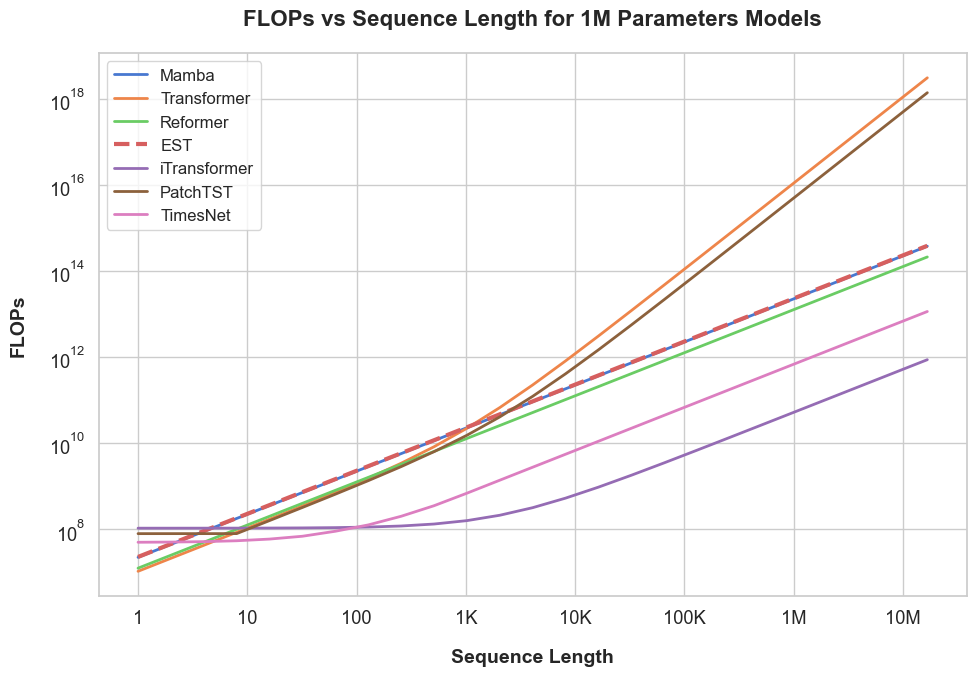

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", font_scale=1.2, palette="muted")

sns.lineplot(x=SEQ_LENGTHS, y=flops_mamba, label='Mamba', linewidth=2)
sns.lineplot(x=SEQ_LENGTHS, y=flops_transformer_vanilla, label='Transformer', linewidth=2)
sns.lineplot(x=SEQ_LENGTHS, y=flops_reformer, label='Reformer', linewidth=2)
sns.lineplot(x=SEQ_LENGTHS, y=flops_est, label='EST', linestyle='--', linewidth=3)
sns.lineplot(x=SEQ_LENGTHS, y=flops_itransformer, label='iTransformer', linewidth=2)
sns.lineplot(x=SEQ_LENGTHS, y=flops_patchtst, label='PatchTST', linewidth=2)
sns.lineplot(x=SEQ_LENGTHS, y=flops_timesnet, label='TimesNet', linewidth=2)

plt.xlabel('Sequence Length', fontsize=14, labelpad=15, weight='bold')
plt.ylabel('FLOPs', fontsize=14, labelpad=15, weight='bold')
plt.yscale('log')
plt.xscale('log')
plt.xticks([1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7], ['1', '10', '100', '1K', '10K', '100K', '1M', '10M'])
plt.title('FLOPs vs Sequence Length for 1M Parameters Models', fontsize=16, weight='bold', pad=20)
plt.legend(fontsize=12, title_fontsize=13, loc='upper left', frameon=True)
plt.tight_layout()
plt.show()